In [ ]:
# Uncomment the line below to install needed libraries and modules if not available on the system
# !pip install matplotlib, numpy, seaborn, sqlite3, fireducks, pandas, scikit-learn, python-dotenv, pprint, warnings, shap, catboost, lightgbm, category-encoders, scikit-optimize

In [1]:
# Import needed modules
import category_encoders as ce
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import shap
import sqlite3
import sys
import warnings
try:
    import fireducks.pandas as pd
except ImportError:
    import pandas as pd
    pd.set_option("mode.copy_on_write", True)
from catboost import CatBoostRegressor
from dotenv import load_dotenv
from IPython.core.display import HTML
from IPython.display import display
from lightgbm import LGBMRegressor
from matplotlib import rcParams
from os.path import expanduser, realpath
from pprint import pprint
from sklearn.dummy import DummyRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_pinball_loss, PredictionErrorDisplay, make_scorer
from sklearn.model_selection import cross_validate, train_test_split, HalvingGridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Monkey patching NumPy for compatibility with version >= 1.24
np.float = np.float64
np.int = np.int_
np.object = np.object_
np.bool = np.bool_

In [4]:
# Define constants
GOLDEN_RATIO = 1.618033989
FIG_WIDTH = 12
FIG_HEIGHT = FIG_WIDTH / GOLDEN_RATIO
FIG_SIZE = (FIG_WIDTH, FIG_HEIGHT)
FIG_DPI = 72
RANDOM_SAMPLE_SIZE = 13
RANDOM_SEED = 42
ALPHA_VALUE = 0.05

In [5]:
# Plotting parameters
rcParams["figure.figsize"] = FIG_SIZE
rcParams["figure.dpi"] = FIG_DPI
rcParams["savefig.format"] = "svg"

In [6]:
load_dotenv(".env")

from utils.utils import table_snapshot, display_table_exec_result, create_sql_connection, execute_on_database, standardise_column_names, timing_function

In [7]:
sys.path.append(realpath(expanduser("../../../snippets_n_gists/data_utils")))

from model_optimiser import model_optimiser

In [8]:
# Get database connection details from environmental variables
HOST_NAME = os.environ.get("DB_HOST")
USER_NAME = os.environ.get("DB_USER")
USER_PASSWORD = os.environ.get("DB_PASSWORD")
DB_PORT = os.environ.get("DB_PORT")
DB_NAME = os.environ.get("DB_NAME")

In [9]:
# Some utility functions

def scatterplot(df, feature, label, num_dp=4, linecolour="darkorange"):
    """
    Creates a scatterplot between two features in a DataFrame, with a regression line included.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data
    feature : str
        The feature to plot on the x-axis
    label : str
        The feature to plot on the y-axis
    num_dp : int
        The number of decimal places to round the regression equation to
    linecolour : str
        The colour of the regression line

    Returns
    -------
    None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    try:
        import fireducks.pandas as pd
    except ImportError:
        import pandas as pd
    from scipy import stats

    # Create the plot
    # sns.scatterplot(x=df[feature], y=df[label])
    sns.regplot(x=df[feature], y=df[label], line_kws={"color": linecolour})
    # Calculate the regression line
    ## Normality satisfied
    results = stats.linregress(df[feature], df[label])
    slope = results.slope
    slope = round(slope, num_dp)
    intercept = results.intercept
    intercept = round(intercept, num_dp)
    r = results.rvalue
    r = round(r, num_dp)
    p = results.pvalue
    p = round(p, num_dp)
    stderr = results.stderr
    intercept_stderr = results.intercept_stderr
    ## Other linear regressions
    results_k = stats.kendalltau(df[feature], df[label])
    tau = results_k.statistic
    tau = round(tau, num_dp)
    tp = results_k.pvalue
    tp = round(tp, num_dp)
    results_r = stats.spearmanr(df[feature], df[label])
    rho = results_r.statistic
    rho = round(rho, num_dp)
    rp = results_r.pvalue
    rp = round(rp, num_dp)
    ## Skew
    feature_skew = round((df[feature].skew()), num_dp)
    label_skew = round((df[label].skew()), num_dp)
    # Create text string
    text_str = f"y = {slope}x + {intercept}\n"
    text_str += f"r = {r}, p = {p}\n"
    text_str += f"τ = {tau}, p = {tp}\n"
    text_str += f"ρ = {rho}, p = {rp}\n"
    text_str += f"{feature} skew = {feature_skew}\n"
    text_str += f"{label} skew = {label_skew}"
    # Add annotations
    plt.text(0.95, 0.2, text_str, fontsize=12, transform=plt.gcf().transFigure)
    # Show plot
    plt.show()


def bar_chart(df, feature, label, num_dp=4, alpha=0.05, sig_ttest_only=True):
    """
    Creates a bar chart with a one-way ANOVA and pairwise t-tests with Bonferroni correction.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data
    feature : str
        The feature to plot on the x-axis
    label : str
        The feature to plot on the y-axis
    num_dp : int
        The number of decimal places to round the results to
    alpha : float
        The significance level for the t-tests
    sig_ttest_only : bool
        If True, only print the t-tests with p <= alpha / number of ttest comparisons

    Returns
    -------
    None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    try:
        import fireducks.pandas as pd
    except ImportError:
        import pandas as pd
    from scipy import stats

    # Make sure that the feature is categorical and the label is numerical
    if pd.api.types.is_numeric_dtype(df[feature]):
        num = feature
        cat = label
    else:
        num = label
        cat = feature
    # Create the plot
    sns.barplot(x=df[cat], y=df[num])
    # Create the numerical lists to calculate the ANOVA
    groups = df[cat].unique()
    # print(groups)
    group_lists = []
    for g in groups:
        n_list = df[df[cat] == g][num]
        group_lists.append(n_list)
    F, p = stats.f_oneway(*group_lists)
    F, p = round(F, num_dp), round(p, num_dp)
    # Calculate pairwise t-test for groups
    ttests = []
    for i1, g1 in enumerate(groups):
        for i2, g2 in enumerate(groups):
            if i2 > i1:
                list01 = df[df[cat] == g1][num]
                list02 = df[df[cat] == g2][num]
                ttest_result = stats.ttest_ind(list01, list02)
                ttest = ttest_result.statistic
                ttest = round(ttest, num_dp)
                ttest_p = ttest_result.pvalue
                ttest_p = round(ttest_p, num_dp)
                # if ttest_result.df or ttest_result.confidence_interval():
                #     dof = ttest_result.df
                #     dof = round(dof, num_dp)
                #     low_ci = ttest_result.confidence_interval()[0]
                #     low_ci = round(low_ci, num_dp)
                #     high_ci = ttest_result.confidence_interval()[1]
                #     high_ci = round(high_ci, num_dp)
                # ttests.append([f"{g1} vs {g2}", ttest, ttest_p, dof, low_ci, high_ci])
                ttests.append([f"{g1} vs {g2}", ttest, ttest_p])
    # Bonferroni correction -> adjust p-value threshold to be 0.05/number of ttest comparisons
    bonferroni = alpha / len(ttests) if len(ttests) > 0 else 0
    bonferroni = round(bonferroni, num_dp)
    # Create text string
    text_str = f"F: {F}\n"
    text_str += f"p: {p}\n"
    text_str += f"Bonferroni p: {bonferroni}"
    for ttest in ttests:
        if sig_ttest_only:
            if ttest[2] <= bonferroni:
                # text_str += f"\n{ttest[0]}: t = {ttest[1]}, p = {ttest[2]}, dof = {ttest[3]}, CI = [{ttest[4]}, {ttest[5]}]"
                text_str += f"\n{ttest[0]}:\n     t = {ttest[1]}, p = {ttest[2]}"
        else:
            text_str += f"\n{ttest[0]}: t = {ttest[1]}, p = {ttest[2]}"
    # If there are too many feature groups, print x labels vertically
    if df[feature].nunique() > 7:
        plt.xticks(rotation=90)
    # Annotations
    plt.text(0.95, 0.1, text_str, fontsize=12, transform=plt.gcf().transFigure)
    # Show plot
    plt.show()


def crosstab(df, feature, label, num_dp=4):
    """
    Creates a heatmap of a contingency table between two categorical features in a DataFrame and calculates the Chi-Squared statistic.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data
    feature : str
        The feature to plot on the x-axis
    label : str
        The feature to plot on the y-axis
    num_dp : int
        The number of decimal places to round the Chi-Squared results to

    Returns
    -------
    None
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    try:
        import fireducks.pandas as pd
    except ImportError:
        import pandas as pd
    from scipy import stats

    contingency_table = pd.crosstab(df[feature], df[label])
    results = stats.chi2_contingency(contingency_table)
    X2 = results.statistic
    X2 = round(X2, num_dp)
    p = results.pvalue
    p = round(p, num_dp)
    dof = results.dof
    dof = round(dof, num_dp)
    expected_freq = results.expected_freq
    # Create text string
    text_str = f"X2: {X2}\n"
    text_str += f"p: {p}\n"
    text_str += f"dof: {dof}"
    # Annotations
    plt.text(0.95, 0.2, text_str, fontsize=12, transform=plt.gcf().transFigure)
    # Generate heatmap
    ct_df = pd.DataFrame(
        np.rint(expected_freq).astype("int64"),
        columns=contingency_table.columns,
        index=contingency_table.index,
    )
    sns.heatmap(ct_df, annot=True, fmt="d", cmap="coolwarm")
    # Show plot
    plt.show()


def bivariate_stats(df, label, num_dp=4):
    """
    Generates a DataFrame containing a variety of bivariate statistics for each feature in a DataFrame vs a given label.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data
    label : str
        The label to be used for the target variable
    num_dp : int
        The number of decimal places to round the results to

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the results of the bivariate statistics
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    try:
        import fireducks.pandas as pd
    except ImportError:
        import pandas as pd
    from scipy import stats

    output_df = pd.DataFrame(
        columns=[
            "missing",
            "missing_%",
            "skew",
            "type",
            "num_unique",
            "p",
            "r",
            "tau",
            "rho",
            "y = m(x) + b",
            "F",
            "X2",
        ]
    )

    for feature in df.columns:
        if feature != label:
            # Calculate statistics that apply to all datatypes
            df_temp = df[[feature, label]].copy()
            df_temp = df_temp.dropna().copy()
            missing = df.shape[0] - df_temp.shape[0]
            buffer = (df.shape[0] - df_temp.shape[0]) / df.shape[0]
            missing_pct = round(buffer * 100, num_dp)
            dtype = df_temp[feature].dtype
            num_unique = df_temp[feature].nunique()
            
            if num_unique < 3 or num_unique > 200:
                continue

            if (pd.api.types.is_numeric_dtype(df_temp[feature])) and (
                pd.api.types.is_numeric_dtype(df_temp[label])
            ):
                # Process N2N relationships
                ## Pearson linear regression
                results_p = stats.linregress(df_temp[feature], df_temp[label])
                slope = results_p.slope
                slope = round(slope, num_dp)
                intercept = results_p.intercept
                intercept = round(intercept, num_dp)
                r = results_p.rvalue
                r = round(r, num_dp)
                p = results_p.pvalue
                p = round(p, num_dp)
                stderr = results_p.stderr
                intercept_stderr = results_p.intercept_stderr
                ## Other linear regressions
                results_k = stats.kendalltau(df_temp[feature], df_temp[label])
                tau = results_k.statistic
                tau = round(tau, num_dp)
                tp = results_k.pvalue
                results_r = stats.spearmanr(df_temp[feature], df_temp[label])
                rho = results_r.statistic
                rho = round(rho, num_dp)
                rp = results_r.pvalue
                ## Skew
                skew = round((df_temp[feature].skew()), num_dp)
                output_df.loc[feature] = [
                    missing,
                    f"{missing_pct}%",
                    skew,
                    dtype,
                    num_unique,
                    p,
                    r,
                    tau,
                    rho,
                    f"y = {slope}x + {intercept}",
                    "--",
                    "--",
                ]
                scatterplot(df_temp, feature, label)
            elif not (pd.api.types.is_numeric_dtype(df_temp[feature])) and not (
                pd.api.types.is_numeric_dtype(df_temp[label])
            ):
                # Process C2C relationships
                contingency_table = pd.crosstab(df_temp[feature], df_temp[label])
                results = stats.chi2_contingency(contingency_table)
                X2 = results.statistic
                X2 = round(X2, num_dp)
                p = results.pvalue
                p = round(p, num_dp)
                dof = results.dof
                expected_freq = results.expected_freq
                output_df.loc[feature] = [
                    missing,
                    f"{missing_pct}%",
                    "--",
                    dtype,
                    num_unique,
                    p,
                    "--",
                    "--",
                    "--",
                    "--",
                    "--",
                    X2,
                ]
                crosstab(df_temp, feature, label)
            else:
                # Process C2N and N2C relationships
                if pd.api.types.is_numeric_dtype(df_temp[feature]):
                    num = feature
                    cat = label
                    skew = round((df_temp[feature].skew()), num_dp)
                else:
                    num = label
                    cat = feature
                    skew = "--"
                groups = df_temp[cat].unique()
                group_lists = []
                for g in groups:
                    n_list = df_temp[df_temp[cat] == g][num]
                    group_lists.append(n_list)
                F, p = stats.f_oneway(*group_lists)
                F, p = round(F, num_dp), round(p, num_dp)
                output_df.loc[feature] = [
                    missing,
                    f"{missing_pct}%",
                    skew,
                    dtype,
                    num_unique,
                    p,
                    "--",
                    "--",
                    "--",
                    "--",
                    F,
                    "--",
                ]
                bar_chart(df_temp, cat, num)
    try:
        return output_df.sort_values(by="p", ascending=True)
    except Exception:
        return output_df


In [10]:
# Path to Combo SQLite DB
print(f"sqlite3 module version: {sqlite3.version}")
print(f"SQLite engine version: {sqlite3.sqlite_version}")
PATH_TO_SQLITE_DB = "../../../../zzz_personal/.assets/data/000_common_dataset/datanerd-jobs-dataset-in-sqlite.db"
real_path_to_db = realpath(expanduser(PATH_TO_SQLITE_DB))

sqlite3 module version: 2.6.0
SQLite engine version: 3.44.1


In [11]:
list_all_sqlite_tables_query = """
SELECT
    name
FROM
    sqlite_master
WHERE
    type = 'table';
"""

In [12]:
sqlite_result = execute_on_database(
    db_path=real_path_to_db, sql_query=list_all_sqlite_tables_query
)
table_snapshot("job_postings_fact", db_path=real_path_to_db)
display(sqlite_result)
pprint(pd.DataFrame(sqlite_result), width=59, compact=True)

Connection to SQLite DB using SQLAlchemy successful!
Database operation successful!


ulid_uuidv7  job_id  company_id job_title_short  \
0        None       0           0    Data Analyst   
1        None      55           1  Cloud Engineer   
2        None      66           2    Data Analyst   
3        None      76           3   Data Engineer   
4        None      81           4   Data Engineer   

                             job_title         job_location  \
0               Marketing Data Analyst             Anywhere   
1  Storage and Virtualization Engineer  Kuwait City, Kuwait   
2        Data Analyst et Scientist F/H        Paris, France   
3                        Data Engineer           Denver, CO   
4                        Data Engineer             Anywhere   

                   job_via job_schedule_type  job_work_from_home  \
0             via LinkedIn         Full-time                   1   
1          via Trabajo.org         Full-time                   0   
2  via Emplois Trabajo.org         Full-time                   0   
3             via LinkedIn        Contractor                   0   
4             via LinkedIn        Contractor                   1   

           search_location      job_posted_date  job_no_degree_mention  \
0                   Serbia  2023-09-25 17:46:06                      0   
1                   Kuwait  2023-07-30 17:49:18                      1   
2                   France  2023-07-28 17:28:01                      0   
3  Illinois, United States  2023-04-03 17:14:45                      0   
4                   Canada  2023-03-25 17:25:20                      0   

   job_health_insurance    job_country salary_rate salary_year_avg  \
0                     0         Serbia        None            None   
1                     0         Kuwait        None            None   
2                     0         France        None            None   
3                     0  United States        hour            None   
4                     0         Canada        None            None   

   salary_hour_avg           created_at           updated_at deleted_at  
0              NaN  2025-07-13 09:52:10  2025-07-13 09:52:10       None  
1              NaN  2025-07-13 09:52:10  2025-07-13 09:52:10       None  
2              NaN  2025-07-13 09:52:10  2025-07-13 09:52:10       None  
3             70.0  2025-07-13 09:52:10  2025-07-13 09:52:10       None  
4              NaN  2025-07-13 09:52:10  2025-07-13 09:52:10       None

[('company_dim',),
 ('invoices_2023_fact_table',),
 ('job_postings_fact',),
 ('skills_dim',),
 ('skills_job_dim',),
 ('sqlite_stat1',)]

                       name
0               company_dim
1  invoices_2023_fact_table
2         job_postings_fact
3                skills_dim
4            skills_job_dim
5              sqlite_stat1


In [12]:
list_all_postgres_tables_query = """
SELECT
    table_schema || '.' || table_name
FROM
    information_schema.tables
WHERE
    table_type = 'BASE TABLE'
AND
    table_schema NOT IN ('pg_catalog', 'information_schema');
"""

In [13]:
postgres_result = execute_on_database(
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    sql_query=list_all_postgres_tables_query,
    messages=False,
)

display(postgres_result)
pprint(pd.DataFrame(postgres_result), width=59, compact=True)

[('public.company_dim',),
 ('public.job_postings_fact',),
 ('public.skills_job_dim',),
 ('public.skills_dim',),
 ('public.january_jobs',),
 ('public.february_jobs',),
 ('public.march_jobs',)]

                   ?column?
0        public.company_dim
1  public.job_postings_fact
2     public.skills_job_dim
3         public.skills_dim
4       public.january_jobs
5      public.february_jobs
6         public.march_jobs


In [14]:
postgres_tables_sizes_query = """
SELECT n.nspname AS table_schema,
       c.relname AS table_name,
       c.reltuples AS rows
FROM
    pg_class c
    JOIN
    pg_namespace n 
    ON
    n.oid = c.relnamespace
WHERE
    c.relkind = 'r' AND n.nspname NOT IN ('information_schema','pg_catalog')
ORDER BY
    c.reltuples desc
;
"""

postgres_tables_sizes_result = execute_on_database(
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    sql_query=postgres_tables_sizes_query,
    messages=False,
)

display(postgres_tables_sizes_result)
pprint(pd.DataFrame(postgres_tables_sizes_result), width=59, compact=True)

[('public', 'skills_job_dim', 3669604.0),
 ('public', 'job_postings_fact', 787686.0),
 ('public', 'company_dim', 140033.0),
 ('public', 'january_jobs', 92266.0),
 ('public', 'february_jobs', 64560.0),
 ('public', 'march_jobs', 64158.0),
 ('public', 'skills_dim', 259.0)]

  table_schema         table_name       rows
0       public     skills_job_dim  3669604.0
1       public  job_postings_fact   787686.0
2       public        company_dim   140033.0
3       public       january_jobs    92266.0
4       public      february_jobs    64560.0
5       public         march_jobs    64158.0
6       public         skills_dim      259.0


In [16]:
sqlite_tables_sizes_query = """
SELECT * 
FROM
    sqlite_stat1
ORDER BY
    stat DESC
;
"""

sqlite_tables_sizes_result = execute_on_database(
    db_path=real_path_to_db, sql_query=sqlite_tables_sizes_query
)
display(sqlite_tables_sizes_result)
pprint(pd.DataFrame(sqlite_tables_sizes_result), width=59, compact=True)

Connection to SQLite DB using SQLAlchemy successful!
Database operation successful!


[('job_postings_fact', None, '787686'),
 ('invoices_2023_fact_table', None, '46477'),
 ('skills_job_dim', None, '3669604'),
 ('skills_dim', None, '259'),
 ('company_dim', None, '140033')]

                        tbl   idx     stat
0         job_postings_fact  None   787686
1  invoices_2023_fact_table  None    46477
2            skills_job_dim  None  3669604
3                skills_dim  None      259
4               company_dim  None   140033


In [14]:
# Tables in database
company_dim = "company_dim"
job_postings_fact = "job_postings_fact"
skills_dim = "skills_dim"
skills_job_dim = "skills_job_dim"

In [17]:
table_snapshot("company_dim", db_path=real_path_to_db)

ulid_uuidv7  company_id                        name  \
0        None           0                  Cryptology   
1        None           1                      Edraak   
2        None           2                  Groupe ADP   
3        None           3  Interactive Resources - iR   
4        None           4           Cybernetic Search   

                       link  \
0                      None   
1                      None   
2  http://www.groupeadp.fr/   
3                      None   
4                      None   

                                         link_google  \
0  https://www.google.com/search?sca_esv=56842508...   
1  https://www.google.com/search?hl=en&gl=us&q=Ed...   
2  https://www.google.com/search?gl=us&hl=en&q=Gr...   
3  https://www.google.com/search?q=Interactive+Re...   
4  https://www.google.com/search?gl=us&hl=en&q=Cy...   

                                           thumbnail           created_at  \
0  https://encrypted-tbn0.gstatic.com/images?q=tb...  2025-07-13 09:50:17   
1  https://encrypted-tbn0.gstatic.com/images?q=tb...  2025-07-13 09:50:17   
2  https://encrypted-tbn0.gstatic.com/images?q=tb...  2025-07-13 09:50:17   
3  https://encrypted-tbn0.gstatic.com/images?q=tb...  2025-07-13 09:50:17   
4  https://encrypted-tbn0.gstatic.com/images?q=tb...  2025-07-13 09:50:17   

            updated_at deleted_at  
0  2025-07-13 09:50:17       None  
1  2025-07-13 09:50:17       None  
2  2025-07-13 09:50:17       None  
3  2025-07-13 09:50:17       None  
4  2025-07-13 09:50:17       None

In [18]:
table_snapshot("job_postings_fact", db_path=real_path_to_db)

ulid_uuidv7  job_id  company_id job_title_short  \
0        None       0           0    Data Analyst   
1        None      55           1  Cloud Engineer   
2        None      66           2    Data Analyst   
3        None      76           3   Data Engineer   
4        None      81           4   Data Engineer   

                             job_title         job_location  \
0               Marketing Data Analyst             Anywhere   
1  Storage and Virtualization Engineer  Kuwait City, Kuwait   
2        Data Analyst et Scientist F/H        Paris, France   
3                        Data Engineer           Denver, CO   
4                        Data Engineer             Anywhere   

                   job_via job_schedule_type  job_work_from_home  \
0             via LinkedIn         Full-time                   1   
1          via Trabajo.org         Full-time                   0   
2  via Emplois Trabajo.org         Full-time                   0   
3             via LinkedIn        Contractor                   0   
4             via LinkedIn        Contractor                   1   

           search_location      job_posted_date  job_no_degree_mention  \
0                   Serbia  2023-09-25 17:46:06                      0   
1                   Kuwait  2023-07-30 17:49:18                      1   
2                   France  2023-07-28 17:28:01                      0   
3  Illinois, United States  2023-04-03 17:14:45                      0   
4                   Canada  2023-03-25 17:25:20                      0   

   job_health_insurance    job_country salary_rate salary_year_avg  \
0                     0         Serbia        None            None   
1                     0         Kuwait        None            None   
2                     0         France        None            None   
3                     0  United States        hour            None   
4                     0         Canada        None            None   

   salary_hour_avg           created_at           updated_at deleted_at  
0              NaN  2025-07-13 09:52:10  2025-07-13 09:52:10       None  
1              NaN  2025-07-13 09:52:10  2025-07-13 09:52:10       None  
2              NaN  2025-07-13 09:52:10  2025-07-13 09:52:10       None  
3             70.0  2025-07-13 09:52:10  2025-07-13 09:52:10       None  
4              NaN  2025-07-13 09:52:10  2025-07-13 09:52:10       None

In [26]:
table_snapshot("skills_dim", db_path=real_path_to_db)

ulid_uuidv7  skill_id  skills         type           created_at  \
0        None         0     sql  programming  2025-07-13 09:54:32   
1        None         1  python  programming  2025-07-13 09:54:32   
2        None         2   nosql  programming  2025-07-13 09:54:32   
3        None         3   scala  programming  2025-07-13 09:54:32   
4        None         4    java  programming  2025-07-13 09:54:32   

            updated_at deleted_at  
0  2025-07-13 09:54:32       None  
1  2025-07-13 09:54:32       None  
2  2025-07-13 09:54:32       None  
3  2025-07-13 09:54:32       None  
4  2025-07-13 09:54:32       None

In [27]:
table_snapshot("skills_job_dim", db_path=real_path_to_db)

ulid_uuidv7  job_id  skill_id           created_at           updated_at  \
0        None       0         0  2025-07-13 10:04:20  2025-07-13 10:04:20   
1        None       0         1  2025-07-13 10:04:20  2025-07-13 10:04:20   
2        None      66         1  2025-07-13 10:04:20  2025-07-13 10:04:20   
3        None      76         0  2025-07-13 10:04:20  2025-07-13 10:04:20   
4        None      76         1  2025-07-13 10:04:20  2025-07-13 10:04:20   

  deleted_at  
0       None  
1       None  
2       None  
3       None  
4       None

# Summary of Findings from Analysis

---

### About The Project

#### Goals

1. An aspiring data nerd looking to analyse top-paying roles and skill.

2. Create SQL queries to explore this large dataset about role(s) of interest.

#### Questions to Answer

1. What are the top-paying jobs for roles that interest me?

2. What are the skills required for these top-paying roles?

3. What are the most in-demand skills for these roles?

4. What are the top skills based on salary for these roles?

5. What are the most optimal skills to learn? (Optimal: High Demand AND High Paying).

6. What are the features and discoveries related to Nigeria?

7. What are the features and discoveries related to Germany?

### Q1. What are the top-paying data analyst, data scientist and data engineer jobs? Identify the top 10 highest-paying Data Analyst/Scientist/Engineer roles that are available remotely.

In [30]:
postgres_top_data_analyst_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Analyst' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_analyst_remote_jobs_query,
)


job_id                                        job_title job_location  \
0   226942                                     Data Analyst     Anywhere   
1   547382                            Director of Analytics     Anywhere   
2   552322                Associate Director- Data Insights     Anywhere   
3    99305                          Data Analyst, Marketing     Anywhere   
4  1021647                     Data Analyst (Hybrid/Remote)     Anywhere   
5   168310                  Principal Data Analyst (Remote)     Anywhere   
6   731368                  Director, Data Analyst - HYBRID     Anywhere   
7   310660  Principal Data Analyst, AV Performance Analysis     Anywhere   
8  1749593                           Principal Data Analyst     Anywhere   
9   387860                                 ERM Data Analyst     Anywhere   

  job_schedule_type salary_year_avg     job_posted_date  \
0         Full-time        650000.0 2023-02-20 15:13:33   
1         Full-time        336500.0 2023-08-23 12:04:42   
2         Full-time        255829.5 2023-06-18 16:03:12   
3         Full-time        232423.0 2023-12-05 20:00:40   
4         Full-time        217000.0 2023-01-17 00:17:23   
5         Full-time        205000.0 2023-08-09 11:00:01   
6         Full-time        189309.0 2023-12-07 15:00:13   
7         Full-time        189000.0 2023-01-05 00:00:25   
8         Full-time        186000.0 2023-07-11 16:00:05   
9         Full-time        184000.0 2023-06-09 08:01:04   

                              company_name  
0                                   Mantys  
1                                     Meta  
2                                     AT&T  
3             Pinterest Job Advertisements  
4                        Uclahealthcareers  
5                               SmartAsset  
6                              Inclusively  
7                                 Motional  
8                               SmartAsset  
9  Get It Recruit - Information Technology

Function: `display_table_exec_result` took --> 618377891ns (0.618s)


In [32]:
sqlite_top_data_analyst_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Analyst' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""


display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_analyst_remote_jobs_query,
)

job_id                                        job_title job_location  \
0   226942                                     Data Analyst     Anywhere   
1   547382                            Director of Analytics     Anywhere   
2   552322                Associate Director- Data Insights     Anywhere   
3    99305                          Data Analyst, Marketing     Anywhere   
4  1021647                     Data Analyst (Hybrid/Remote)     Anywhere   
5   168310                  Principal Data Analyst (Remote)     Anywhere   
6   731368                  Director, Data Analyst - HYBRID     Anywhere   
7   310660  Principal Data Analyst, AV Performance Analysis     Anywhere   
8  1749593                           Principal Data Analyst     Anywhere   
9   387860                                 ERM Data Analyst     Anywhere   

  job_schedule_type  salary_year_avg      job_posted_date  \
0         Full-time         650000.0  2023-02-20 15:13:33   
1         Full-time         336500.0  2023-08-23 12:04:42   
2         Full-time         255829.5  2023-06-18 16:03:12   
3         Full-time         232423.0  2023-12-05 20:00:40   
4         Full-time         217000.0  2023-01-17 00:17:23   
5         Full-time         205000.0  2023-08-09 11:00:01   
6         Full-time         189309.0  2023-12-07 15:00:13   
7         Full-time         189000.0  2023-01-05 00:00:25   
8         Full-time         186000.0  2023-07-11 16:00:05   
9         Full-time         184000.0  2023-06-09 08:01:04   

                              company_name  
0                                   Mantys  
1                                     Meta  
2                                     AT&T  
3             Pinterest Job Advertisements  
4                        Uclahealthcareers  
5                               SmartAsset  
6                              Inclusively  
7                                 Motional  
8                               SmartAsset  
9  Get It Recruit - Information Technology

Function: `display_table_exec_result` took --> 956981092ns (0.957s)


In [33]:
postgres_top_data_scientist_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Scientist' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_scientist_remote_jobs_query,
)


job_id                                          job_title job_location  \
0    40145              Staff Data Scientist/Quant Researcher     Anywhere   
1  1714768          Staff Data Scientist - Business Analytics     Anywhere   
2  1131472                                     Data Scientist     Anywhere   
3  1742633                               Head of Data Science     Anywhere   
4   551497                               Head of Data Science     Anywhere   
5   126218  Director Level - Product Management - Data Sci...     Anywhere   
6  1161630               Director of Data Science & Analytics     Anywhere   
7    38905                           Principal Data Scientist     Anywhere   
8   457991                       Head of Battery Data Science     Anywhere   
9   129924                           Director of Data Science     Anywhere   

  job_schedule_type salary_year_avg     job_posted_date        company_name  
0         Full-time        550000.0 2023-08-16 16:05:16      Selby Jennings  
1         Full-time        525000.0 2023-09-01 19:24:02      Selby Jennings  
2         Full-time        375000.0 2023-07-31 14:05:21  Algo Capital Group  
3         Full-time        351500.0 2023-07-12 03:07:31          Demandbase  
4         Full-time        324000.0 2023-05-26 22:04:44          Demandbase  
5         Full-time        320000.0 2023-03-26 23:46:39            Teramind  
6         Full-time        313000.0 2023-08-23 22:03:48              Reddit  
7         Full-time        300000.0 2023-11-24 14:08:44              Storm5  
8         Full-time        300000.0 2023-10-02 16:40:07     Lawrence Harvey  
9         Full-time        300000.0 2023-01-21 11:09:36              Storm4

Function: `display_table_exec_result` took --> 258535346ns (0.259s)


In [34]:
sqlite_top_data_scientist_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Scientist' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""


display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_scientist_remote_jobs_query,
)

job_id                                          job_title job_location  \
0    40145              Staff Data Scientist/Quant Researcher     Anywhere   
1  1714768          Staff Data Scientist - Business Analytics     Anywhere   
2  1131472                                     Data Scientist     Anywhere   
3  1742633                               Head of Data Science     Anywhere   
4   551497                               Head of Data Science     Anywhere   
5   126218  Director Level - Product Management - Data Sci...     Anywhere   
6  1161630               Director of Data Science & Analytics     Anywhere   
7   457991                       Head of Battery Data Science     Anywhere   
8   129924                           Director of Data Science     Anywhere   
9   226011                       Distinguished Data Scientist     Anywhere   

  job_schedule_type  salary_year_avg      job_posted_date        company_name  
0         Full-time         550000.0  2023-08-16 16:05:16      Selby Jennings  
1         Full-time         525000.0  2023-09-01 19:24:02      Selby Jennings  
2         Full-time         375000.0  2023-07-31 14:05:21  Algo Capital Group  
3         Full-time         351500.0  2023-07-12 03:07:31          Demandbase  
4         Full-time         324000.0  2023-05-26 22:04:44          Demandbase  
5         Full-time         320000.0  2023-03-26 23:46:39            Teramind  
6         Full-time         313000.0  2023-08-23 22:03:48              Reddit  
7         Full-time         300000.0  2023-10-02 16:40:07     Lawrence Harvey  
8         Full-time         300000.0  2023-01-21 11:09:36              Storm4  
9         Full-time         300000.0  2023-08-06 11:00:43             Walmart

Function: `display_table_exec_result` took --> 324108906ns (0.324s)


In [173]:
postgres_top_data_engineer_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Engineer' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_engineer_remote_jobs_query,
)


job_id                                job_title job_location  \
0  157003                            Data Engineer     Anywhere   
1   21321                            Data Engineer     Anywhere   
2  270455                            Data Engineer     Anywhere   
3  230458  Director of Engineering - Data Platform     Anywhere   
4  561728                            Data Engineer     Anywhere   
5  543728                      Staff Data Engineer     Anywhere   
6  595768                  Principal Data Engineer     Anywhere   
7  151972         Principal Data Engineer (Remote)     Anywhere   
8  204320                      Staff Data Engineer     Anywhere   
9    2446                 Data Engineering Manager     Anywhere   

  job_schedule_type salary_year_avg     job_posted_date        company_name  
0         Full-time        325000.0 2023-02-17 18:11:49              Engtal  
1         Full-time        325000.0 2023-01-27 18:10:51              Engtal  
2         Full-time        300000.0 2023-07-17 11:10:55   Durlston Partners  
3         Full-time        251000.0 2023-01-30 11:07:32              Twitch  
4         Full-time        250000.0 2023-03-24 23:32:42          AI Startup  
5         Full-time        250000.0 2023-03-28 13:11:42  Signify Technology  
6         Full-time        250000.0 2023-02-14 15:24:07  Signify Technology  
7         Full-time        245000.0 2023-05-25 15:05:38         Movable Ink  
8         Full-time        245000.0 2023-01-08 15:05:16           Handshake  
9         Full-time        242000.0 2023-12-12 15:56:17                Meta

Function: `display_table_exec_result` took --> 294353585ns (0.294s)


In [ ]:
sqlite_top_data_engineer_remote_jobs_query = f"""
SELECT
    job_id,
    job_title,
    job_location,
    job_schedule_type,
    salary_year_avg,
    job_posted_date,
    name AS company_name
FROM
    job_postings_fact
    LEFT JOIN
    company_dim
    ON
    job_postings_fact.company_id = company_dim.company_id
WHERE
    job_title_short = 'Data Engineer' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
ORDER BY
    salary_year_avg DESC
LIMIT 10
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_engineer_remote_jobs_query,
)

job_id                                job_title job_location  \
0   21321                            Data Engineer     Anywhere   
1  157003                            Data Engineer     Anywhere   
2  270455                            Data Engineer     Anywhere   
3  230458  Director of Engineering - Data Platform     Anywhere   
4  595768                  Principal Data Engineer     Anywhere   
5  561728                            Data Engineer     Anywhere   
6  543728                      Staff Data Engineer     Anywhere   
7  151972         Principal Data Engineer (Remote)     Anywhere   
8  204320                      Staff Data Engineer     Anywhere   
9    2446                 Data Engineering Manager     Anywhere   

  job_schedule_type  salary_year_avg      job_posted_date        company_name  
0         Full-time         325000.0  2023-01-27 18:10:51              Engtal  
1         Full-time         325000.0  2023-02-17 18:11:49              Engtal  
2         Full-time         300000.0  2023-07-17 11:10:55   Durlston Partners  
3         Full-time         251000.0  2023-01-30 11:07:32              Twitch  
4         Full-time         250000.0  2023-02-14 15:24:07  Signify Technology  
5         Full-time         250000.0  2023-03-24 23:32:42          AI Startup  
6         Full-time         250000.0  2023-03-28 13:11:42  Signify Technology  
7         Full-time         245000.0  2023-05-25 15:05:38         Movable Ink  
8         Full-time         245000.0  2023-01-08 15:05:16           Handshake  
9         Full-time         242000.0  2023-12-12 15:56:17                Meta

Function: `display_table_exec_result` took --> 542702028ns (0.543s)


---

### Q2. What skills are required for the top-paying data analyst, data scientist and data engineer jobs? Identify the top 10 highest-paying Data Analyst/Scientist/Engineer jobs from the first query. Add the specific skills required for these roles.

In [175]:

postgres_top_data_analyst_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Analyst' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_analyst_jobs_skills_query,
)


job_id                          job_title salary_year_avg  \
0    552322  Associate Director- Data Insights        255829.5   
1    552322  Associate Director- Data Insights        255829.5   
2    552322  Associate Director- Data Insights        255829.5   
3    552322  Associate Director- Data Insights        255829.5   
4    552322  Associate Director- Data Insights        255829.5   
..      ...                                ...             ...   
61  1749593             Principal Data Analyst        186000.0   
62  1749593             Principal Data Analyst        186000.0   
63   387860                   ERM Data Analyst        184000.0   
64   387860                   ERM Data Analyst        184000.0   
65   387860                   ERM Data Analyst        184000.0   

                               company_name   skills  
0                                      AT&T      sql  
1                                      AT&T   python  
2                                      AT&T        r  
3                                      AT&T    azure  
4                                      AT&T      aws  
..                                      ...      ...  
61                               SmartAsset  tableau  
62                               SmartAsset   gitlab  
63  Get It Recruit - Information Technology      sql  
64  Get It Recruit - Information Technology   python  
65  Get It Recruit - Information Technology        r  

[66 rows x 5 columns]

Function: `display_table_exec_result` took --> 269410866ns (0.269s)


In [176]:

sqlite_top_data_analyst_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Analyst' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_analyst_jobs_skills_query,
)


job_id                          job_title  salary_year_avg  \
0    552322  Associate Director- Data Insights         255829.5   
1    552322  Associate Director- Data Insights         255829.5   
2    552322  Associate Director- Data Insights         255829.5   
3    552322  Associate Director- Data Insights         255829.5   
4    552322  Associate Director- Data Insights         255829.5   
..      ...                                ...              ...   
61  1749593             Principal Data Analyst         186000.0   
62  1749593             Principal Data Analyst         186000.0   
63   387860                   ERM Data Analyst         184000.0   
64   387860                   ERM Data Analyst         184000.0   
65   387860                   ERM Data Analyst         184000.0   

                               company_name      skills  
0                                      AT&T         sql  
1                                      AT&T      python  
2                                      AT&T           r  
3                                      AT&T       azure  
4                                      AT&T  databricks  
..                                      ...         ...  
61                               SmartAsset     tableau  
62                               SmartAsset      gitlab  
63  Get It Recruit - Information Technology         sql  
64  Get It Recruit - Information Technology      python  
65  Get It Recruit - Information Technology           r  

[66 rows x 5 columns]

Function: `display_table_exec_result` took --> 6359439034ns (6.359s)


In [ ]:
postgres_top_data_scientist_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Scientist' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_scientist_jobs_skills_query,
)


job_id                                          job_title  \
0     40145              Staff Data Scientist/Quant Researcher   
1     40145              Staff Data Scientist/Quant Researcher   
2   1714768          Staff Data Scientist - Business Analytics   
3   1131472                                     Data Scientist   
4   1131472                                     Data Scientist   
5   1131472                                     Data Scientist   
6   1131472                                     Data Scientist   
7   1131472                                     Data Scientist   
8   1131472                                     Data Scientist   
9   1131472                                     Data Scientist   
10   126218  Director Level - Product Management - Data Sci...   
11   126218  Director Level - Product Management - Data Sci...   
12   126218  Director Level - Product Management - Data Sci...   
13   126218  Director Level - Product Management - Data Sci...   
14   126218  Director Level - Product Management - Data Sci...   
15   126218  Director Level - Product Management - Data Sci...   
16   126218  Director Level - Product Management - Data Sci...   
17   457991                       Head of Battery Data Science   
18   457991                       Head of Battery Data Science   
19   457991                       Head of Battery Data Science   
20   226011                       Distinguished Data Scientist   
21   226011                       Distinguished Data Scientist   
22   226011                       Distinguished Data Scientist   
23   226011                       Distinguished Data Scientist   
24   226011                       Distinguished Data Scientist   
25   226011                       Distinguished Data Scientist   
26    38905                           Principal Data Scientist   
27    38905                           Principal Data Scientist   
28    38905                           Principal Data Scientist   
29    38905                           Principal Data Scientist   
30    38905                           Principal Data Scientist   
31    38905                           Principal Data Scientist   

   salary_year_avg        company_name        skills  
0         550000.0      Selby Jennings        python  
1         550000.0      Selby Jennings           sql  
2         525000.0      Selby Jennings           sql  
3         375000.0  Algo Capital Group        python  
4         375000.0  Algo Capital Group          java  
5         375000.0  Algo Capital Group           sql  
6         375000.0  Algo Capital Group     cassandra  
7         375000.0  Algo Capital Group        hadoop  
8         375000.0  Algo Capital Group         spark  
9         375000.0  Algo Capital Group       tableau  
10        320000.0            Teramind           aws  
11        320000.0            Teramind         azure  
12        320000.0            Teramind    tensorflow  
13        320000.0            Teramind         keras  
14        320000.0            Teramind       pytorch  
15        320000.0            Teramind  scikit-learn  
16        320000.0            Teramind     datarobot  
17        300000.0     Lawrence Harvey        python  
18        300000.0     Lawrence Harvey           aws  
19        300000.0     Lawrence Harvey           gcp  
20        300000.0             Walmart          java  
21        300000.0             Walmart         scala  
22        300000.0             Walmart    tensorflow  
23        300000.0             Walmart       pytorch  
24        300000.0             Walmart         spark  
25        300000.0             Walmart    kubernetes  
26        300000.0              Storm5             c  
27        300000.0              Storm5        python  
28        300000.0              Storm5          java  
29        300000.0              Storm5           sql  
30        300000.0              Storm5           aws  
31        300000.0              Storm5           gcp

Function: `display_table_exec_result` took --> 257289972ns (0.257s)


In [ ]:
sqlite_top_data_scientist_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Scientist' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_scientist_jobs_skills_query,
)


job_id                                          job_title  \
0     40145              Staff Data Scientist/Quant Researcher   
1     40145              Staff Data Scientist/Quant Researcher   
2   1714768          Staff Data Scientist - Business Analytics   
3   1131472                                     Data Scientist   
4   1131472                                     Data Scientist   
5   1131472                                     Data Scientist   
6   1131472                                     Data Scientist   
7   1131472                                     Data Scientist   
8   1131472                                     Data Scientist   
9   1131472                                     Data Scientist   
10   126218  Director Level - Product Management - Data Sci...   
11   126218  Director Level - Product Management - Data Sci...   
12   126218  Director Level - Product Management - Data Sci...   
13   126218  Director Level - Product Management - Data Sci...   
14   126218  Director Level - Product Management - Data Sci...   
15   126218  Director Level - Product Management - Data Sci...   
16   126218  Director Level - Product Management - Data Sci...   
17   457991                       Head of Battery Data Science   
18   457991                       Head of Battery Data Science   
19   457991                       Head of Battery Data Science   
20   129924                           Director of Data Science   
21   129924                           Director of Data Science   
22   129924                           Director of Data Science   
23   226011                       Distinguished Data Scientist   
24   226011                       Distinguished Data Scientist   
25   226011                       Distinguished Data Scientist   
26   226011                       Distinguished Data Scientist   
27   226011                       Distinguished Data Scientist   
28   226011                       Distinguished Data Scientist   

    salary_year_avg        company_name        skills  
0          550000.0      Selby Jennings           sql  
1          550000.0      Selby Jennings        python  
2          525000.0      Selby Jennings           sql  
3          375000.0  Algo Capital Group           sql  
4          375000.0  Algo Capital Group        python  
5          375000.0  Algo Capital Group          java  
6          375000.0  Algo Capital Group     cassandra  
7          375000.0  Algo Capital Group         spark  
8          375000.0  Algo Capital Group        hadoop  
9          375000.0  Algo Capital Group       tableau  
10         320000.0            Teramind         azure  
11         320000.0            Teramind           aws  
12         320000.0            Teramind    tensorflow  
13         320000.0            Teramind         keras  
14         320000.0            Teramind       pytorch  
15         320000.0            Teramind  scikit-learn  
16         320000.0            Teramind     datarobot  
17         300000.0     Lawrence Harvey        python  
18         300000.0     Lawrence Harvey           aws  
19         300000.0     Lawrence Harvey           gcp  
20         300000.0              Storm4        python  
21         300000.0              Storm4        pandas  
22         300000.0              Storm4         numpy  
23         300000.0             Walmart         scala  
24         300000.0             Walmart          java  
25         300000.0             Walmart         spark  
26         300000.0             Walmart    tensorflow  
27         300000.0             Walmart       pytorch  
28         300000.0             Walmart    kubernetes

Function: `display_table_exec_result` took --> 6709419997ns (6.709s)


In [ ]:
postgres_top_data_engineer_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Engineer' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_engineer_jobs_skills_query,
)


job_id                                job_title salary_year_avg  \
0    21321                            Data Engineer        325000.0   
1    21321                            Data Engineer        325000.0   
2    21321                            Data Engineer        325000.0   
3    21321                            Data Engineer        325000.0   
4    21321                            Data Engineer        325000.0   
5    21321                            Data Engineer        325000.0   
6    21321                            Data Engineer        325000.0   
7    21321                            Data Engineer        325000.0   
8   157003                            Data Engineer        325000.0   
9   157003                            Data Engineer        325000.0   
10  157003                            Data Engineer        325000.0   
11  157003                            Data Engineer        325000.0   
12  157003                            Data Engineer        325000.0   
13  157003                            Data Engineer        325000.0   
14  157003                            Data Engineer        325000.0   
15  157003                            Data Engineer        325000.0   
16  270455                            Data Engineer        300000.0   
17  270455                            Data Engineer        300000.0   
18  230458  Director of Engineering - Data Platform        251000.0   
19  230458  Director of Engineering - Data Platform        251000.0   
20  230458  Director of Engineering - Data Platform        251000.0   
21  230458  Director of Engineering - Data Platform        251000.0   
22  230458  Director of Engineering - Data Platform        251000.0   
23  230458  Director of Engineering - Data Platform        251000.0   
24  561728                            Data Engineer        250000.0   
25  561728                            Data Engineer        250000.0   
26  561728                            Data Engineer        250000.0   
27  561728                            Data Engineer        250000.0   
28  595768                  Principal Data Engineer        250000.0   
29  595768                  Principal Data Engineer        250000.0   
30  595768                  Principal Data Engineer        250000.0   
31  595768                  Principal Data Engineer        250000.0   
32  543728                      Staff Data Engineer        250000.0   
33  543728                      Staff Data Engineer        250000.0   
34  543728                      Staff Data Engineer        250000.0   
35  543728                      Staff Data Engineer        250000.0   
36  204320                      Staff Data Engineer        245000.0   
37  151972         Principal Data Engineer (Remote)        245000.0   
38  151972         Principal Data Engineer (Remote)        245000.0   
39  151972         Principal Data Engineer (Remote)        245000.0   
40  609418                 Data Engineering Manager        242000.0   
41  609418                 Data Engineering Manager        242000.0   
42  609418                 Data Engineering Manager        242000.0   
43  609418                 Data Engineering Manager        242000.0   

          company_name      skills  
0               Engtal      python  
1               Engtal      pandas  
2               Engtal       numpy  
3               Engtal     pyspark  
4               Engtal      hadoop  
5               Engtal       spark  
6               Engtal       kafka  
7               Engtal  kubernetes  
8               Engtal      python  
9               Engtal      pandas  
10              Engtal       numpy  
11              Engtal     pyspark  
12              Engtal      hadoop  
13              Engtal       spark  
14              Engtal       kafka  
15              Engtal  kubernetes  
16   Durlston Partners      python  
17   Durlston Partners         sql  
18              Twitch       spark  
19              Twitch      hadoop  
20              Twitch       ka

Function: `display_table_exec_result` took --> 243326033ns (0.243s)


In [ ]:
sqlite_top_data_engineer_jobs_skills_query = f"""
WITH top_paying_jobs AS (
    SELECT
        job_id,
        job_title,
        salary_year_avg,
        name AS company_name
    FROM
        job_postings_fact
        LEFT JOIN
        company_dim
        ON
        job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Engineer' AND job_location = 'Anywhere' AND salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
)

SELECT
    top_paying_jobs.*,
    skills
FROM
    top_paying_jobs
    INNER JOIN
    skills_job_dim AS sjd
    ON
    top_paying_jobs.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
ORDER BY
    salary_year_avg DESC
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_engineer_jobs_skills_query,
)


job_id                                job_title  salary_year_avg  \
0    21321                            Data Engineer         325000.0   
1    21321                            Data Engineer         325000.0   
2    21321                            Data Engineer         325000.0   
3    21321                            Data Engineer         325000.0   
4    21321                            Data Engineer         325000.0   
5    21321                            Data Engineer         325000.0   
6    21321                            Data Engineer         325000.0   
7    21321                            Data Engineer         325000.0   
8   157003                            Data Engineer         325000.0   
9   157003                            Data Engineer         325000.0   
10  157003                            Data Engineer         325000.0   
11  157003                            Data Engineer         325000.0   
12  157003                            Data Engineer         325000.0   
13  157003                            Data Engineer         325000.0   
14  157003                            Data Engineer         325000.0   
15  157003                            Data Engineer         325000.0   
16  270455                            Data Engineer         300000.0   
17  270455                            Data Engineer         300000.0   
18  230458  Director of Engineering - Data Platform         251000.0   
19  230458  Director of Engineering - Data Platform         251000.0   
20  230458  Director of Engineering - Data Platform         251000.0   
21  230458  Director of Engineering - Data Platform         251000.0   
22  230458  Director of Engineering - Data Platform         251000.0   
23  230458  Director of Engineering - Data Platform         251000.0   
24  595768                  Principal Data Engineer         250000.0   
25  595768                  Principal Data Engineer         250000.0   
26  595768                  Principal Data Engineer         250000.0   
27  595768                  Principal Data Engineer         250000.0   
28  561728                            Data Engineer         250000.0   
29  561728                            Data Engineer         250000.0   
30  561728                            Data Engineer         250000.0   
31  561728                            Data Engineer         250000.0   
32  543728                      Staff Data Engineer         250000.0   
33  543728                      Staff Data Engineer         250000.0   
34  543728                      Staff Data Engineer         250000.0   
35  543728                      Staff Data Engineer         250000.0   
36  151972         Principal Data Engineer (Remote)         245000.0   
37  151972         Principal Data Engineer (Remote)         245000.0   
38  151972         Principal Data Engineer (Remote)         245000.0   
39  204320                      Staff Data Engineer         245000.0   
40    2446                 Data Engineering Manager         242000.0   
41    2446                 Data Engineering Manager         242000.0   
42    2446                 Data Engineering Manager         242000.0   
43    2446                 Data Engineering Manager         242000.0   

          company_name      skills  
0               Engtal      python  
1               Engtal       spark  
2               Engtal      pandas  
3               Engtal       numpy  
4               Engtal     pyspark  
5               Engtal      hadoop  
6               Engtal       kafka  
7               Engtal  kubernetes  
8               Engtal      python  
9               Engtal       spark  
10              Engtal      pandas  
11              Engtal       numpy  
12              Engtal     pyspark  
13              Engtal      hadoop  
14              Engtal       kafka  
15              Engtal  kubernetes  
16   Durlston Partners         sql  
17   Durlston Partners      python  
18              Twitch       spark  
19              Twitch 

Function: `display_table_exec_result` took --> 7044313342ns (7.044s)


---

### Q3. What are the most in-demand skills? Identify the top 7 in-demand skills for a data analyst, data scientist and data engineer from all job postings.

skills  demand_count
0       sql         92628
1     excel         67031
2    python         57326
3   tableau         46554
4  power bi         39468
5         r         30075
6       sas         28068

Function: `display_table_exec_result` took --> 1230639346ns (1.231s)


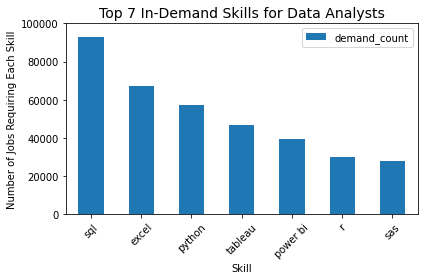

In [84]:
postgres_top_in_demand_skills_for_data_analyst_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

postgres_top_in_demand_skills_for_data_analyst_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_in_demand_skills_for_data_analyst_query,
    return_df=True
)

postgres_top_in_demand_skills_for_data_analyst_query_result.plot.bar(x="skills", y="demand_count")
plt.ylim(0, 100000)
plt.xticks(rotation=45)
plt.xlabel("Skill")
plt.ylabel("Number of Jobs Requiring Each Skill")
plt.title("Top 7 In-Demand Skills for Data Analysts", fontsize=14)
plt.tight_layout()

In [ ]:
sqlite_top_in_demand_skills_for_data_analyst_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_in_demand_skills_for_data_analyst_query,
)

skills  demand_count
0       sql         92628
1     excel         67031
2    python         57326
3   tableau         46554
4  power bi         39468
5         r         30075
6       sas         28068

Function: `display_table_exec_result` took --> 35746075851ns (35.746s)


skills  demand_count
0   python        114016
1      sql         79174
2        r         59754
3      sas         29642
4  tableau         29513
5      aws         26311
6    spark         24353

Function: `display_table_exec_result` took --> 1388816137ns (1.389s)


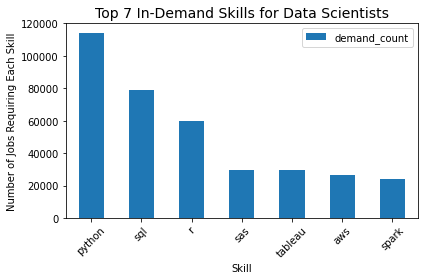

In [86]:
postgres_top_in_demand_skills_for_data_scientist_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

postgres_top_in_demand_skills_for_data_scientist_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_in_demand_skills_for_data_scientist_query,
    return_df=True
)

postgres_top_in_demand_skills_for_data_scientist_query_result.plot.bar(x="skills", y="demand_count")
plt.ylim(0, 120000)
plt.xticks(rotation=45)
plt.xlabel("Skill")
plt.ylabel("Number of Jobs Requiring Each Skill")
plt.title("Top 7 In-Demand Skills for Data Scientists", fontsize=14)
plt.tight_layout()

In [ ]:
sqlite_top_in_demand_skills_for_data_scientist_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_in_demand_skills_for_data_scientist_query,
)

skills  demand_count
0   python        114016
1      sql         79174
2        r         59754
3      sas         29642
4  tableau         29513
5      aws         26311
6    spark         24353

Function: `display_table_exec_result` took --> 32342596887ns (32.343s)


skills  demand_count
0     sql        113375
1  python        108265
2     aws         62174
3   azure         60823
4   spark         53789
5    java         35642
6   kafka         29163

Function: `display_table_exec_result` took --> 1605847796ns (1.606s)


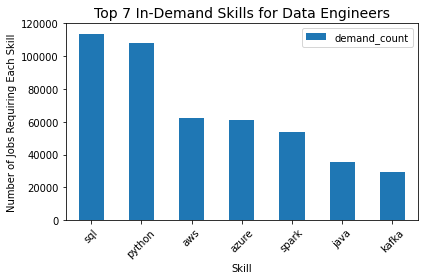

In [88]:
postgres_top_in_demand_skills_for_data_engineer_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

postgres_top_in_demand_skills_for_data_engineer_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_in_demand_skills_for_data_engineer_query,
    return_df=True
)

postgres_top_in_demand_skills_for_data_engineer_query_result.plot.bar(x="skills", y="demand_count")
plt.ylim(0, 120000)
plt.xticks(rotation=45)
plt.xlabel("Skill")
plt.ylabel("Number of Jobs Requiring Each Skill")
plt.title("Top 7 In-Demand Skills for Data Engineers", fontsize=14)
plt.tight_layout()

In [ ]:
sqlite_top_in_demand_skills_for_data_engineer_query = f"""
SELECT
    skills,
    COUNT(sjd.job_id) AS demand_count
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer'
GROUP BY
    skills
ORDER BY
    demand_count DESC
LIMIT 7
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_in_demand_skills_for_data_engineer_query,
)

skills  demand_count
0     sql        113375
1  python        108265
2     aws         62174
3   azure         60823
4   spark         53789
5    java         35642
6   kafka         29163

Function: `display_table_exec_result` took --> 35227797172ns (35.228s)


---

### Q4. What are the top skills based on salary? Look at the average salary associated with each skill for data analyst, data scientist and data engineer positions regardless of location.

In [188]:
postgres_top_data_analyst_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_analyst_skills_based_on_salary_query,
)

skills avg_salary
0            svn     400000
1       solidity     179000
2      couchbase     160515
3      datarobot     155486
4         golang     155000
5          mxnet     149000
6          dplyr     147633
7         vmware     147500
8      terraform     146734
9         twilio     138500
10        gitlab     134126
11         kafka     129999
12        puppet     129820
13         keras     127013
14       pytorch     125226
15          perl     124686
16       ansible     124370
17  hugging face     123950
18    tensorflow     120647
19     cassandra     118407
20        notion     118092
21     atlassian     117966
22     bitbucket     116712
23       airflow     116387
24         scala     115480

Function: `display_table_exec_result` took --> 628710519ns (0.629s)


In [189]:
sqlite_top_data_analyst_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_analyst_skills_based_on_salary_query,
)

skills  avg_salary
0            svn    400000.0
1       solidity    179000.0
2      couchbase    160515.0
3      datarobot    155486.0
4         golang    155000.0
5          mxnet    149000.0
6          dplyr    147633.0
7         vmware    147500.0
8      terraform    146734.0
9         twilio    138500.0
10        gitlab    134126.0
11         kafka    129999.0
12        puppet    129820.0
13         keras    127013.0
14       pytorch    125226.0
15          perl    124686.0
16       ansible    124370.0
17  hugging face    123950.0
18    tensorflow    120647.0
19     cassandra    118407.0
20        notion    118092.0
21     atlassian    117966.0
22     bitbucket    116712.0
23       airflow    116387.0
24         scala    115480.0

Function: `display_table_exec_result` took --> 6848316592ns (6.848s)


In [190]:
postgres_top_data_scientist_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_scientist_skills_based_on_salary_query,
)

skills avg_salary
0           asana     215477
1        airtable     201143
2          redhat     189500
3          watson     187417
4          elixir     170824
5             lua     170500
6           slack     168219
7        solidity     166980
8   ruby on rails     166500
9          rshiny     166436
10         notion     165636
11    objective-c     164500
12          neo4j     163971
13          dplyr     163111
14   hugging face     160868
15       dynamodb     160581
16        haskell     157500
17          unity     156881
18        airflow     155878
19     codecommit     154684
20         unreal     153278
21         theano     153133
22           zoom     151677
23       bigquery     149292
24      atlassian     148715

Function: `display_table_exec_result` took --> 653120339ns (0.653s)


In [191]:
sqlite_top_data_scientist_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_scientist_skills_based_on_salary_query,
)

skills  avg_salary
0           asana    215477.0
1        airtable    201143.0
2          redhat    189500.0
3          watson    187417.0
4          elixir    170824.0
5             lua    170500.0
6           slack    168219.0
7        solidity    166980.0
8   ruby on rails    166500.0
9          rshiny    166436.0
10         notion    165636.0
11    objective-c    164500.0
12          neo4j    163971.0
13          dplyr    163111.0
14   hugging face    160868.0
15       dynamodb    160581.0
16        haskell    157500.0
17          unity    156881.0
18        airflow    155878.0
19     codecommit    154684.0
20         unreal    153278.0
21         theano    153133.0
22           zoom    151677.0
23       bigquery    149292.0
24      atlassian    148715.0

Function: `display_table_exec_result` took --> 7037578513ns (7.038s)


In [192]:
postgres_top_data_engineer_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_top_data_engineer_skills_based_on_salary_query,
)

skills avg_salary
0         node     181862
1        mongo     179403
2      ggplot2     176250
3     solidity     166250
4          vue     159375
5   codecommit     155000
6       ubuntu     154455
7      clojure     153663
8    cassandra     150255
9         rust     147771
10      drupal     147500
11        perl     145540
12     next.js     145000
13     angular     143319
14       scala     143161
15       kafka     143086
16        gdpr     142369
17       shell     141725
18       macos     141617
19       numpy     141605
20      opencv     141250
21   atlassian     140644
22   ibm cloud     140547
23      splunk     140156
24  kubernetes     140092

Function: `display_table_exec_result` took --> 535402611ns (0.535s)


In [193]:
sqlite_top_data_engineer_skills_based_on_salary_query = f"""
SELECT
    skills,
    ROUND(AVG(salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact
    INNER JOIN
    skills_job_dim AS sjd
    ON
    job_postings_fact.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL
GROUP BY
    skills
ORDER BY
    avg_salary DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_top_data_engineer_skills_based_on_salary_query,
)

skills  avg_salary
0         node    181862.0
1        mongo    179403.0
2      ggplot2    176250.0
3     solidity    166250.0
4          vue    159375.0
5   codecommit    155000.0
6       ubuntu    154455.0
7      clojure    153663.0
8    cassandra    150255.0
9         rust    147771.0
10      drupal    147500.0
11        perl    145540.0
12     next.js    145000.0
13     angular    143319.0
14       scala    143161.0
15       kafka    143086.0
16        gdpr    142369.0
17       shell    141725.0
18       macos    141617.0
19       numpy    141605.0
20      opencv    141250.0
21   atlassian    140644.0
22   ibm cloud    140547.0
23      splunk    140156.0
24  kubernetes    140092.0

Function: `display_table_exec_result` took --> 6652743017ns (6.653s)


---

### Q5. What are the most optimal skills to learn (aka it is in high demand and a high-paying skill)? Identify skills in high demand and associated with high average salaries for data analyst, data scientist and data engineer roles with concentration on remote positions with specified salaries while ensuring the number of job postings is more than 10.

##### --- Data analyst ---

In [198]:
# Using CTE
postgres_above_10_optimal_remote_data_analyst_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_analyst_skills_cte_query,
)

skill_id      skills  demand_count avg_salary
0          8          go            27     115320
1        234  confluence            11     114210
2         97      hadoop            22     113193
3         80   snowflake            37     112948
4         74       azure            34     111225
5         77    bigquery            13     109654
6         76         aws            32     108317
7          4        java            17     106906
8        194        ssis            12     106683
9        233        jira            20     104918
10        79      oracle            37     104534
11       185      looker            49     103795
12         2       nosql            13     101414
13         1      python           236     101397
14         5           r           148     100499
15        78    redshift            16      99936
16       187        qlik            13      99631
17       182     tableau           230      99288
18       197        ssrs            14      99171
19        92       spark            13      99077
20        13         c++            11      98958
21       186         sas            63      98902
22         7         sas            63      98902
23        61  sql server            35      97786
24         9  javascript            20      97587

Function: `display_table_exec_result` took --> 366205740ns (0.366s)


In [199]:
# Using JOIN and HAVING
postgres_above_10_optimal_remote_data_analyst_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_analyst_skills_query,
)

skill_id      skills  demand_count avg_salary
0          8          go            27     115320
1        234  confluence            11     114210
2         97      hadoop            22     113193
3         80   snowflake            37     112948
4         74       azure            34     111225
5         77    bigquery            13     109654
6         76         aws            32     108317
7          4        java            17     106906
8        194        ssis            12     106683
9        233        jira            20     104918
10        79      oracle            37     104534
11       185      looker            49     103795
12         2       nosql            13     101414
13         1      python           236     101397
14         5           r           148     100499
15        78    redshift            16      99936
16       187        qlik            13      99631
17       182     tableau           230      99288
18       197        ssrs            14      99171
19        92       spark            13      99077
20        13         c++            11      98958
21       186         sas            63      98902
22         7         sas            63      98902
23        61  sql server            35      97786
24         9  javascript            20      97587

Function: `display_table_exec_result` took --> 242132134ns (0.242s)


In [200]:
# Using CTE
sqlite_above_10_optimal_remote_data_analyst_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_analyst_skills_cte_query,
)

skill_id      skills  demand_count  avg_salary
0          8          go            27    115320.0
1        234  confluence            11    114210.0
2         97      hadoop            22    113193.0
3         80   snowflake            37    112948.0
4         74       azure            34    111225.0
5         77    bigquery            13    109654.0
6         76         aws            32    108317.0
7          4        java            17    106906.0
8        194        ssis            12    106683.0
9        233        jira            20    104918.0
10        79      oracle            37    104534.0
11       185      looker            49    103795.0
12         2       nosql            13    101414.0
13         1      python           236    101397.0
14         5           r           148    100499.0
15        78    redshift            16     99936.0
16       187        qlik            13     99631.0
17       182     tableau           230     99288.0
18       197        ssrs            14     99171.0
19        92       spark            13     99077.0
20        13         c++            11     98958.0
21         7         sas            63     98902.0
22       186         sas            63     98902.0
23        61  sql server            35     97786.0
24         9  javascript            20     97587.0

Function: `display_table_exec_result` took --> 13075339967ns (13.075s)


In [201]:
# Using JOIN and HAVING
sqlite_above_10_optimal_remote_data_analyst_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_analyst_skills_query,
)

skill_id      skills  demand_count  avg_salary
0          8          go            27    115320.0
1        234  confluence            11    114210.0
2         97      hadoop            22    113193.0
3         80   snowflake            37    112948.0
4         74       azure            34    111225.0
5         77    bigquery            13    109654.0
6         76         aws            32    108317.0
7          4        java            17    106906.0
8        194        ssis            12    106683.0
9        233        jira            20    104918.0
10        79      oracle            37    104534.0
11       185      looker            49    103795.0
12         2       nosql            13    101414.0
13         1      python           236    101397.0
14         5           r           148    100499.0
15        78    redshift            16     99936.0
16       187        qlik            13     99631.0
17       182     tableau           230     99288.0
18       197        ssrs            14     99171.0
19        92       spark            13     99077.0
20        13         c++            11     98958.0
21         7         sas            63     98902.0
22       186         sas            63     98902.0
23        61  sql server            35     97786.0
24         9  javascript            20     97587.0

Function: `display_table_exec_result` took --> 6801800950ns (6.802s)


##### --- Data scientist ---

In [203]:
# Using CTE
postgres_above_10_optimal_remote_data_scientist_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_scientist_skills_cte_query,
)

skill_id      skills  demand_count avg_salary
0          8          go            27     164691
1        187        qlik            13     164485
2        185      looker            49     158715
3         77    bigquery            13     157142
4         80   snowflake            37     152687
5         78    redshift            16     151708
6        233        jira            20     151165
7         92       spark            13     150188
8         76         aws            32     149630
9        182     tableau           230     146970
10         2       nosql            13     146110
11         4        java            17     145706
12       196  powerpoint            58     145139
13         1      python           236     143828
14        97      hadoop            22     143322
15         0         sql           398     142833
16        74       azure            34     142306
17       215        flow            28     140027
18       234  confluence            11     139484
19         5           r           148     137885
20       183    power bi           110     131390
21       199        spss            24     131101
22       195  sharepoint            18     130186
23       186         sas            63     129920
24         7         sas            63     129920

Function: `display_table_exec_result` took --> 378776605ns (0.379s)


In [204]:
# Using JOIN and HAVING
postgres_above_10_optimal_remote_data_scientist_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_scientist_skills_query,
)

skill_id        skills  demand_count avg_salary
0         26             c            48     164865
1          8            go            57     164691
2        187          qlik            15     164485
3        185        looker            57     158715
4         96       airflow            23     157414
5         77      bigquery            36     157142
6          3         scala            56     156702
7         81           gcp            59     155811
8         80     snowflake            72     152687
9        101       pytorch           115     152603
10        78      redshift            36     151708
11        99    tensorflow           126     151536
12       233          jira            22     151165
13        92         spark           149     150188
14        76           aws           217     149630
15        94         numpy            73     149089
16       106  scikit-learn            81     148964
17        95       pyspark            34     147544
18       182       tableau           219     146970
19         2         nosql            31     146110
20         4          java            64     145706
21       196    powerpoint            23     145139
22        93        pandas           113     144816
23       213    kubernetes            25     144498
24         1        python           763     143828

Function: `display_table_exec_result` took --> 379769370ns (0.380s)


In [205]:
# Using CTE
sqlite_above_10_optimal_remote_data_scientist_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_scientist_skills_cte_query,
)

skill_id      skills  demand_count  avg_salary
0          8          go            27    164691.0
1        187        qlik            13    164485.0
2        185      looker            49    158715.0
3         77    bigquery            13    157142.0
4         80   snowflake            37    152687.0
5         78    redshift            16    151708.0
6        233        jira            20    151165.0
7         92       spark            13    150188.0
8         76         aws            32    149630.0
9        182     tableau           230    146970.0
10         2       nosql            13    146110.0
11         4        java            17    145706.0
12       196  powerpoint            58    145139.0
13         1      python           236    143828.0
14        97      hadoop            22    143322.0
15         0         sql           398    142833.0
16        74       azure            34    142306.0
17       215        flow            28    140027.0
18       234  confluence            11    139484.0
19         5           r           148    137885.0
20       183    power bi           110    131390.0
21       199        spss            24    131101.0
22       195  sharepoint            18    130186.0
23         7         sas            63    129920.0
24       186         sas            63    129920.0

Function: `display_table_exec_result` took --> 13236868432ns (13.237s)


In [206]:
# Using JOIN and HAVING
sqlite_above_10_optimal_remote_data_scientist_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Scientist' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_scientist_skills_query,
)

skill_id        skills  demand_count  avg_salary
0         26             c            48    164865.0
1          8            go            57    164691.0
2        187          qlik            15    164485.0
3        185        looker            57    158715.0
4         96       airflow            23    157414.0
5         77      bigquery            36    157142.0
6          3         scala            56    156702.0
7         81           gcp            59    155811.0
8         80     snowflake            72    152687.0
9        101       pytorch           115    152603.0
10        78      redshift            36    151708.0
11        99    tensorflow           126    151536.0
12       233          jira            22    151165.0
13        92         spark           149    150188.0
14        76           aws           217    149630.0
15        94         numpy            73    149089.0
16       106  scikit-learn            81    148964.0
17        95       pyspark            34    147544.0
18       182       tableau           219    146970.0
19         2         nosql            31    146110.0
20         4          java            64    145706.0
21       196    powerpoint            23    145139.0
22        93        pandas           113    144816.0
23       213    kubernetes            25    144498.0
24         1        python           763    143828.0

Function: `display_table_exec_result` took --> 6412052927ns (6.412s)


##### --- Data engineer ---

In [207]:
# Using CTE
postgres_above_10_optimal_remote_data_engineer_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_engineer_skills_cte_query,
)

skill_id      skills  demand_count avg_salary
0         92       spark            13     139838
1          4        java            17     138087
2         97      hadoop            22     137707
3          2       nosql            13     136430
4        234  confluence            11     136333
5        185      looker            49     134614
6         80   snowflake            37     134373
7         78    redshift            16     132980
8         76         aws            32     132865
9          1      python           236     132200
10       198     outlook            13     129905
11        74       azure            34     129574
12       233        jira            20     129562
13         0         sql           398     129191
14        77    bigquery            13     126627
15         8          go            27     125006
16       215        flow            28     123866
17       201     alteryx            17     122545
18        79      oracle            37     121980
19        61  sql server            35     121364
20         9  javascript            20     121358
21         5           r           148     121065
22       188        word            48     121055
23       183    power bi           110     116949
24       197        ssrs            14     116758

Function: `display_table_exec_result` took --> 435164152ns (0.435s)


In [208]:
# Using JOIN and HAVING
postgres_above_10_optimal_remote_data_engineer_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_above_10_optimal_remote_data_engineer_skills_query,
)

skill_id         skills  demand_count avg_salary
0        213     kubernetes            56     158190
1         94          numpy            14     157592
2         63      cassandra            19     151282
3         98          kafka           134     150549
4         27         golang            11     147818
5        212      terraform            44     146057
6         93         pandas            38     144656
7         59  elasticsearch            21     144102
8        144           ruby            14     144000
9         30           ruby            14     144000
10        83         aurora            14     142887
11       101        pytorch            11     142254
12         3          scala           113     141777
13        92          spark           237     139838
14        95        pyspark            64     139428
15        64       dynamodb            27     138883
16        18        mongodb            32     138569
17        62        mongodb            32     138569
18        96        airflow           151     138518
19         4           java           139     138087
20        97         hadoop            98     137707
21        17     typescript            19     137207
22         2          nosql            93     136430
23         6          shell            34     135499
24       185         looker            30     134614

Function: `display_table_exec_result` took --> 204208450ns (0.204s)


In [209]:
# Using CTE
sqlite_above_10_optimal_remote_data_engineer_skills_cte_query = f"""
WITH skills_demand AS (
    SELECT
        sd.skill_id,
        sd.skills,
        COUNT(sjd.job_id) AS demand_count
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sd.skill_id
),

average_salary AS (
    SELECT
        sjd.skill_id,
        -- skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
        INNER JOIN
        skills_job_dim AS sjd
        ON
        job_postings_fact.job_id = sjd.job_id
        INNER JOIN
        skills_dim AS sd
        ON
        sd.skill_id = sjd.skill_id
    WHERE
        job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
    GROUP BY
        sjd.skill_id
)

SELECT
    skills_demand.skill_id,
    skills_demand.skills,
    demand_count,
    avg_salary
FROM
    skills_demand
    INNER JOIN
    average_salary
    ON
    skills_demand.skill_id = average_salary.skill_id
WHERE
    demand_count > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_engineer_skills_cte_query,
)

skill_id      skills  demand_count  avg_salary
0         92       spark            13    139838.0
1          4        java            17    138087.0
2         97      hadoop            22    137707.0
3          2       nosql            13    136430.0
4        234  confluence            11    136333.0
5        185      looker            49    134614.0
6         80   snowflake            37    134373.0
7         78    redshift            16    132980.0
8         76         aws            32    132865.0
9          1      python           236    132200.0
10       198     outlook            13    129905.0
11        74       azure            34    129574.0
12       233        jira            20    129562.0
13         0         sql           398    129191.0
14        77    bigquery            13    126627.0
15         8          go            27    125006.0
16       215        flow            28    123866.0
17       201     alteryx            17    122545.0
18        79      oracle            37    121980.0
19        61  sql server            35    121364.0
20         9  javascript            20    121358.0
21         5           r           148    121065.0
22       188        word            48    121055.0
23       183    power bi           110    116949.0
24       197        ssrs            14    116758.0

Function: `display_table_exec_result` took --> 12814950487ns (12.815s)


In [210]:
# Using JOIN and HAVING
sqlite_above_10_optimal_remote_data_engineer_skills_query = f"""
SELECT
    sd.skill_id,
    sd.skills,
    COUNT(sjd.job_id) AS demand_count,
    ROUND(AVG(jpf.salary_year_avg), 0) AS avg_salary
FROM
    job_postings_fact AS jpf
    INNER JOIN
    skills_job_dim AS sjd
    ON
    jpf.job_id = sjd.job_id
    INNER JOIN
    skills_dim AS sd
    ON
    sd.skill_id = sjd.skill_id
WHERE
    job_title_short = 'Data Engineer' AND salary_year_avg IS NOT NULL AND job_work_from_home = True
GROUP BY
    sd.skill_id
HAVING
    COUNT(sjd.job_id) > 10
ORDER BY
    avg_salary DESC,
    demand_count DESC
LIMIT 25
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_above_10_optimal_remote_data_engineer_skills_query,
)

skill_id         skills  demand_count  avg_salary
0        213     kubernetes            56    158190.0
1         94          numpy            14    157592.0
2         63      cassandra            19    151282.0
3         98          kafka           134    150549.0
4         27         golang            11    147818.0
5        212      terraform            44    146057.0
6         93         pandas            38    144656.0
7         59  elasticsearch            21    144102.0
8         30           ruby            14    144000.0
9        144           ruby            14    144000.0
10        83         aurora            14    142887.0
11       101        pytorch            11    142254.0
12         3          scala           113    141777.0
13        92          spark           237    139838.0
14        95        pyspark            64    139428.0
15        64       dynamodb            27    138883.0
16        18        mongodb            32    138569.0
17        62        mongodb            32    138569.0
18        96        airflow           151    138518.0
19         4           java           139    138087.0
20        97         hadoop            98    137707.0
21        17     typescript            19    137207.0
22         2          nosql            93    136430.0
23         6          shell            34    135499.0
24       185         looker            30    134614.0

Function: `display_table_exec_result` took --> 6530378862ns (6.530s)


---

### Q6. What are the features and discoveries related to Nigeria and Germany versus the rest of the world?

In [214]:
nigeria_salary_range_query = f"""
SELECT
    job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	job_location LIKE 'Nigeria'
GROUP BY
    job_location
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=nigeria_salary_range_query,
)

job_location min_salary avg_salary max_salary
0      Nigeria    69300.0    84650.0   100000.0

Function: `display_table_exec_result` took --> 338481383ns (0.338s)


In [219]:
germany_salary_range_query = f"""
SELECT
    job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	job_location LIKE 'Germany'
GROUP BY
    job_location
;
"""

display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=germany_salary_range_query,
)

job_location min_salary avg_salary max_salary
0      Germany    49896.0   131498.5   198000.0

Function: `display_table_exec_result` took --> 349975743ns (0.350s)


In [37]:
worldwide_salary_min_mean_median_max_query = f"""
WITH sql_median AS (
SELECT ROUND(AVG(salary_year_avg), 1) AS median
FROM (
	SELECT
		salary_year_avg
	FROM
		job_postings_fact
	WHERE
		salary_year_avg IS NOT NULL
	ORDER BY
		salary_year_avg
	LIMIT 2 - (SELECT COUNT(*) FROM job_postings_fact WHERE salary_year_avg IS NOT NULL) % 2
	OFFSET
		(SELECT (COUNT(*) - 1) / 2 FROM job_postings_fact WHERE salary_year_avg IS NOT NULL)
        
) AS subquery
WHERE
	salary_year_avg IS NOT NULL
)

SELECT
    'Worldwide' AS job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
	(SELECT * FROM sql_median) AS median_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	salary_year_avg IS NOT NULL
;
"""

worldwide_salary_min_mean_median_max_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=worldwide_salary_min_mean_median_max_query,
    return_df=True
)

job_location min_salary avg_salary median_salary max_salary
0    Worldwide    15000.0   123268.8      115000.0   960000.0

Function: `display_table_exec_result` took --> 928543023ns (0.929s)


In [46]:
nigeria_salary_min_mean_median_max_query = f"""
WITH sql_median AS (
SELECT ROUND(AVG(salary_year_avg), 1) AS median
FROM (
	SELECT
		salary_year_avg
	FROM
		job_postings_fact
	WHERE
		salary_year_avg IS NOT NULL AND job_location LIKE 'Nigeria'
	ORDER BY
		salary_year_avg
	LIMIT 2 - (SELECT COUNT(*) FROM job_postings_fact WHERE salary_year_avg IS NOT NULL AND job_location LIKE 'Nigeria') % 2
	OFFSET
		(SELECT (COUNT(*) - 1) / 2 FROM job_postings_fact WHERE salary_year_avg IS NOT NULL AND job_location LIKE 'Nigeria')
        
) AS subquery
WHERE
	salary_year_avg IS NOT NULL
)

SELECT
    job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
	(SELECT * FROM sql_median) AS median_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	salary_year_avg IS NOT NULL AND job_location LIKE 'Nigeria'
GROUP BY
    job_location
;
"""

nigeria_salary_min_mean_median_max_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=nigeria_salary_min_mean_median_max_query,
    return_df=True
)

job_location min_salary avg_salary median_salary max_salary
0      Nigeria    69300.0    84650.0       84650.0   100000.0

Function: `display_table_exec_result` took --> 569098435ns (0.569s)


In [48]:
germany_salary_min_mean_median_max_query = f"""
WITH sql_median AS (
SELECT ROUND(AVG(salary_year_avg), 1) AS median
FROM (
	SELECT
		salary_year_avg
	FROM
		job_postings_fact
	WHERE
		salary_year_avg IS NOT NULL AND job_location LIKE 'Germany'
	ORDER BY
		salary_year_avg
	LIMIT 2 - (SELECT COUNT(*) FROM job_postings_fact WHERE salary_year_avg IS NOT NULL AND job_location LIKE 'Germany') % 2
	OFFSET
		(SELECT (COUNT(*) - 1) / 2 FROM job_postings_fact WHERE salary_year_avg IS NOT NULL AND job_location LIKE 'Germany')
        
) AS subquery
WHERE
	salary_year_avg IS NOT NULL
)

SELECT
    job_location,
    MIN(salary_year_avg) AS min_salary,
    ROUND(AVG(salary_year_avg), 1) AS avg_salary,
	(SELECT * FROM sql_median) AS median_salary,
    MAX(salary_year_avg) AS max_salary
FROM
    job_postings_fact
WHERE
	salary_year_avg IS NOT NULL AND job_location LIKE 'Germany'
GROUP BY
    job_location
;
"""

germany_salary_min_mean_median_max_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=germany_salary_min_mean_median_max_query,
    return_df=True
)

job_location min_salary avg_salary median_salary max_salary
0      Germany    49896.0   131498.5      147500.0   198000.0

Function: `display_table_exec_result` took --> 543227107ns (0.543s)


In [65]:
min_mean_median_max_query_result = pd.concat([worldwide_salary_min_mean_median_max_query_result, nigeria_salary_min_mean_median_max_query_result, germany_salary_min_mean_median_max_query_result])

In [68]:
convert_to_numeric = ["min_salary", "avg_salary", "median_salary", "max_salary"]

for column in convert_to_numeric:
    min_mean_median_max_query_result[column] = pd.to_numeric(min_mean_median_max_query_result[column], errors="coerce", downcast="float")


In [ ]:
min_mean_median_max_query_result.info()

In [89]:
min_mean_median_max_query_result

job_location  min_salary  avg_salary  median_salary  max_salary
0    Worldwide     15000.0    123268.8       115000.0    960000.0
0      Nigeria     69300.0     84650.0        84650.0    100000.0
0      Germany     49896.0    131498.5       147500.0    198000.0

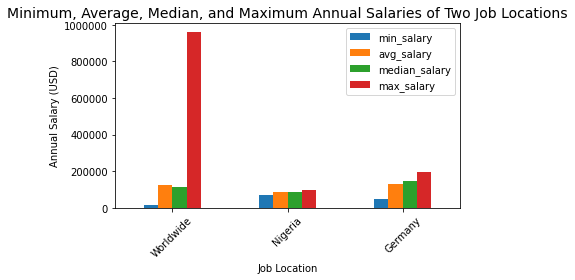

In [78]:
min_mean_median_max_query_result.plot(x="job_location", y=["min_salary", "avg_salary", "median_salary", "max_salary"], kind="bar")
plt.xticks(rotation=45)
plt.xlabel("Job Location")
plt.ylabel("Annual Salary (USD)")
plt.title("Minimum, Average, Median, and Maximum Annual Salaries of Two Job Locations", fontsize=14)
plt.ticklabel_format(style="plain", axis="y")
plt.tight_layout()

In [264]:
worldwide_remote_vs_onsite_jobs_query = f"""
SELECT
	'Worldwide' AS job_location,
    COUNT(job_id) AS number_of_jobs,
    CASE
        WHEN job_work_from_home = True THEN 'Remote'
        WHEN job_work_from_home = False THEN 'Onsite'
        ELSE 'Unknown'
    END AS location_category
FROM
    job_postings_fact
GROUP BY
	location_category
;
"""

worldwide_remote_vs_onsite_jobs_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=worldwide_remote_vs_onsite_jobs_query,
    return_df=True
)

job_location  number_of_jobs location_category
0    Worldwide          718080            Onsite
1    Worldwide           69606            Remote

Function: `display_table_exec_result` took --> 1280284215ns (1.280s)


In [285]:
nigeria_remote_vs_onsite_jobs_query = f"""
SELECT
	'Nigeria' AS job_location,
    COUNT(job_id) AS number_of_jobs,
    CASE
        WHEN job_work_from_home = True THEN 'Remote'
        WHEN job_work_from_home = False THEN 'Onsite'
        ELSE 'Unknown'
    END AS location_category
FROM
    job_postings_fact
WHERE
    job_country LIKE 'Nigeria'
GROUP BY
	location_category
;
"""

nigeria_remote_vs_onsite_jobs_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=nigeria_remote_vs_onsite_jobs_query,
    return_df=True
)

job_location  number_of_jobs location_category
0      Nigeria             955            Onsite
1      Nigeria              97            Remote

Function: `display_table_exec_result` took --> 368211423ns (0.368s)


In [286]:
germany_remote_vs_onsite_jobs_query = f"""
SELECT
	'Germany' AS job_location,
    COUNT(job_id) AS number_of_jobs,
    CASE
        WHEN job_work_from_home = True THEN 'Remote'
        WHEN job_work_from_home = False THEN 'Onsite'
        ELSE 'Unknown'
    END AS location_category
FROM
    job_postings_fact
WHERE
    job_country LIKE 'Germany'
GROUP BY
	location_category
;
"""

germany_remote_vs_onsite_jobs_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=germany_remote_vs_onsite_jobs_query,
    return_df=True
)

job_location  number_of_jobs location_category
0      Germany           26449            Onsite
1      Germany            1333            Remote

Function: `display_table_exec_result` took --> 296750159ns (0.297s)


In [288]:
united_states_remote_vs_onsite_jobs_query = f"""
SELECT
	'United States' AS job_location,
    COUNT(job_id) AS number_of_jobs,
    CASE
        WHEN job_work_from_home = True THEN 'Remote'
        WHEN job_work_from_home = False THEN 'Onsite'
        ELSE 'Unknown'
    END AS location_category
FROM
    job_postings_fact
WHERE
    job_country LIKE 'United States'
GROUP BY
	location_category
;
"""

united_states_remote_vs_onsite_jobs_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=united_states_remote_vs_onsite_jobs_query,
    return_df=True
)

job_location  number_of_jobs location_category
0  United States          183793            Onsite
1  United States           23150            Remote

Function: `display_table_exec_result` took --> 299163243ns (0.299s)


In [289]:
india_remote_vs_onsite_jobs_query = f"""
SELECT
	'India' AS job_location,
    COUNT(job_id) AS number_of_jobs,
    CASE
        WHEN job_work_from_home = True THEN 'Remote'
        WHEN job_work_from_home = False THEN 'Onsite'
        ELSE 'Unknown'
    END AS location_category
FROM
    job_postings_fact
WHERE
    job_country LIKE 'India'
GROUP BY
	location_category
;
"""

india_remote_vs_onsite_jobs_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=india_remote_vs_onsite_jobs_query,
    return_df=True
)

job_location  number_of_jobs location_category
0        India           45474            Onsite
1        India            5723            Remote

Function: `display_table_exec_result` took --> 395036520ns (0.395s)


In [290]:
remote_vs_onsite_jobs_offers = pd.concat([worldwide_remote_vs_onsite_jobs_query_result, nigeria_remote_vs_onsite_jobs_query_result, germany_remote_vs_onsite_jobs_query_result, united_states_remote_vs_onsite_jobs_query_result, india_remote_vs_onsite_jobs_query_result])

In [291]:
remote_vs_onsite_jobs_offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 1
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job_location       10 non-null     object
 1   number_of_jobs     10 non-null     int64 
 2   location_category  10 non-null     object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


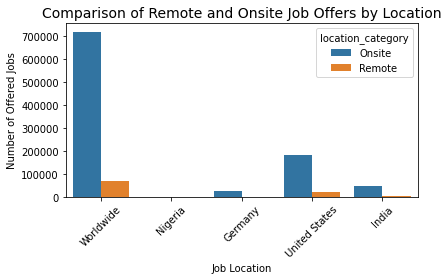

In [292]:
sns.barplot(data=remote_vs_onsite_jobs_offers, x="job_location", y="number_of_jobs", hue="location_category")
plt.xticks(rotation=45)
plt.xlabel("Job Location")
plt.ylabel("Number of Offered Jobs")
plt.title("Comparison of Remote and Onsite Job Offers by Location", fontsize=14)
plt.ticklabel_format(style="plain", axis="y")
plt.tight_layout()

---

## Section 2

In [ ]:
full_dataset_verbose_query = f"""
SELECT DISTINCT
	jpf.job_id,
	jpf.job_title_short AS job_title,
	cd.name AS company_name,
	jpf.job_location AS job_location,
	sd.skills AS skill,
	sd.type AS field,
	jpf.job_via AS job_via,
	jpf.job_schedule_type AS job_schedule,
	jpf.job_work_from_home AS remote_job,
	jpf.job_no_degree_mention AS need_degree,
	jpf.job_health_insurance AS has_insurance,
	jpf.job_country AS country,
	jpf.salary_hour_avg AS hourly_salary,
	jpf.salary_year_avg AS yearly_salary
FROM
	job_postings_fact AS jpf
	LEFT JOIN
	company_dim AS cd
	ON jpf.company_id = cd.company_id
	LEFT JOIN
	skills_job_dim AS sjd
	ON jpf.job_id = sjd.job_id
	LEFT JOIN
	skills_dim AS sd
	ON sjd.skill_id = sd.skill_id
GROUP BY
	jpf.job_id,
    company_name,
	skill,
    field
;
"""

full_dataset_verbose_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=full_dataset_verbose_query,
    return_df=True
)

job_id       job_title      company_name      job_location  \
0              0    Data Analyst        Cryptology          Anywhere   
1              0    Data Analyst        Cryptology          Anywhere   
2              0    Data Analyst        Cryptology          Anywhere   
3              0    Data Analyst        Cryptology          Anywhere   
4              0    Data Analyst        Cryptology          Anywhere   
...          ...             ...               ...               ...   
3786921  1826673  Data Scientist  General Dynamics  Bossier City, LA   
3786922  1826673  Data Scientist  General Dynamics  Bossier City, LA   
3786923  1826673  Data Scientist  General Dynamics  Bossier City, LA   
3786924  1826678  Data Scientist              Citi      New York, NY   
3786925  1826678  Data Scientist              Citi      New York, NY   

            skill          field       job_via job_schedule  remote_job  \
0           excel  analyst_tools  via LinkedIn    Full-time        True   
1        power bi  analyst_tools  via LinkedIn    Full-time        True   
2          python    programming  via LinkedIn    Full-time        True   
3             sql    programming  via LinkedIn    Full-time        True   
4         tableau  analyst_tools  via LinkedIn    Full-time        True   
...           ...            ...           ...          ...         ...   
3786921         r    programming     via BeBee    Full-time       False   
3786922       sql    programming     via BeBee    Full-time       False   
3786923   tableau  analyst_tools     via BeBee    Full-time       False   
3786924    python    programming  via LinkedIn    Full-time       False   
3786925       sql    programming  via LinkedIn    Full-time       False   

         need_degree  has_insurance        country hourly_salary yearly_salary  
0              False          False         Serbia          None          None  
1              False          False         Serbia          None          None  
2              False          False         Serbia          None          None  
3              False          False         Serbia          None          None  
4              False          False         Serbia          None          None  
...              ...            ...            ...           ...           ...  
3786921        False           True  United States          None          None  
3786922        False           True  United States          None          None  
3786923        False           True  United States          None          None  
3786924        False          False  United States          None          None  
3786925        False          False  United States          None          None  

[3786926 rows x 14 columns]

Function: `display_table_exec_result` took --> 53814578093ns (53.815s)


In [ ]:
full_dataset_verbose_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786926 entries, 0 to 3786925
Data columns (total 14 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   job_id         int64 
 1   job_title      object
 2   company_name   object
 3   job_location   object
 4   skill          object
 5   field          object
 6   job_via        object
 7   job_schedule   object
 8   remote_job     bool  
 9   need_degree    bool  
 10  has_insurance  bool  
 11  country        object
 12  hourly_salary  object
 13  yearly_salary  object
dtypes: bool(3), int64(1), object(10)
memory usage: 328.6+ MB


In [ ]:
convert_to_numeric02 = ["hourly_salary", "yearly_salary"]

for column in convert_to_numeric02:
    full_dataset_verbose_query_result[column] = pd.to_numeric(full_dataset_verbose_query_result[column], errors="coerce", downcast="float")

full_dataset_verbose_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786926 entries, 0 to 3786925
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   job_id         int64  
 1   job_title      object 
 2   company_name   object 
 3   job_location   object 
 4   skill          object 
 5   field          object 
 6   job_via        object 
 7   job_schedule   object 
 8   remote_job     bool   
 9   need_degree    bool   
 10  has_insurance  bool   
 11  country        object 
 12  hourly_salary  float32
 13  yearly_salary  float32
dtypes: bool(3), float32(2), int64(1), object(8)
memory usage: 299.8+ MB


In [ ]:
string_columns = ["job_title", "company_name", "job_location", "skill", "field", "job_via", "job_schedule", "country"]

for column in string_columns:
    full_dataset_verbose_query_result[column] = full_dataset_verbose_query_result[column].astype(str)
    full_dataset_verbose_query_result[column] = full_dataset_verbose_query_result[column].str.lower().str.strip()

full_dataset_verbose_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786926 entries, 0 to 3786925
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   job_id         int64  
 1   job_title      object 
 2   company_name   object 
 3   job_location   object 
 4   skill          object 
 5   field          object 
 6   job_via        object 
 7   job_schedule   object 
 8   remote_job     bool   
 9   need_degree    bool   
 10  has_insurance  bool   
 11  country        object 
 12  hourly_salary  float32
 13  yearly_salary  float32
dtypes: bool(3), float32(2), int64(1), object(8)
memory usage: 299.8+ MB


In [ ]:
full_dataset_verbose_query_result

job_id       job_title      company_name      job_location  \
0              0    data analyst        cryptology          anywhere   
1              0    data analyst        cryptology          anywhere   
2              0    data analyst        cryptology          anywhere   
3              0    data analyst        cryptology          anywhere   
4              0    data analyst        cryptology          anywhere   
...          ...             ...               ...               ...   
3786921  1826673  data scientist  general dynamics  bossier city, la   
3786922  1826673  data scientist  general dynamics  bossier city, la   
3786923  1826673  data scientist  general dynamics  bossier city, la   
3786924  1826678  data scientist              citi      new york, ny   
3786925  1826678  data scientist              citi      new york, ny   

            skill          field       job_via job_schedule  remote_job  \
0           excel  analyst_tools  via linkedin    full-time        True   
1        power bi  analyst_tools  via linkedin    full-time        True   
2          python    programming  via linkedin    full-time        True   
3             sql    programming  via linkedin    full-time        True   
4         tableau  analyst_tools  via linkedin    full-time        True   
...           ...            ...           ...          ...         ...   
3786921         r    programming     via bebee    full-time       False   
3786922       sql    programming     via bebee    full-time       False   
3786923   tableau  analyst_tools     via bebee    full-time       False   
3786924    python    programming  via linkedin    full-time       False   
3786925       sql    programming  via linkedin    full-time       False   

         need_degree  has_insurance        country  hourly_salary  \
0              False          False         serbia            NaN   
1              False          False         serbia            NaN   
2              False          False         serbia            NaN   
3              False          False         serbia            NaN   
4              False          False         serbia            NaN   
...              ...            ...            ...            ...   
3786921        False           True  united states            NaN   
3786922        False           True  united states            NaN   
3786923        False           True  united states            NaN   
3786924        False          False  united states            NaN   
3786925        False          False  united states            NaN   

         yearly_salary  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
3786921            NaN  
3786922            NaN  
3786923            NaN  
3786924            NaN  
3786925            NaN  

[3786926 rows x 14 columns]

In [ ]:
convert_to_category = ["job_title", "field", "job_schedule", "country"]

for column in convert_to_category:
    full_dataset_verbose_query_result[column] = full_dataset_verbose_query_result[column].astype("category")

In [ ]:
full_dataset_verbose_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786926 entries, 0 to 3786925
Data columns (total 14 columns):
 #   Column         Dtype   
---  ------         -----   
 0   job_id         int64   
 1   job_title      category
 2   company_name   object  
 3   job_location   object  
 4   skill          object  
 5   field          category
 6   job_via        object  
 7   job_schedule   category
 8   remote_job     bool    
 9   need_degree    bool    
 10  has_insurance  bool    
 11  country        category
 12  hourly_salary  float32 
 13  yearly_salary  float32 
dtypes: bool(3), category(4), float32(2), int64(1), object(4)
memory usage: 202.3+ MB


In [ ]:
full_dataset_verbose_query_result["job_id"] = pd.to_numeric(full_dataset_verbose_query_result["job_id"], errors="coerce", downcast="integer")

In [ ]:
full_dataset_verbose_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786926 entries, 0 to 3786925
Data columns (total 14 columns):
 #   Column         Dtype   
---  ------         -----   
 0   job_id         int32   
 1   job_title      category
 2   company_name   object  
 3   job_location   object  
 4   skill          object  
 5   field          category
 6   job_via        object  
 7   job_schedule   category
 8   remote_job     bool    
 9   need_degree    bool    
 10  has_insurance  bool    
 11  country        category
 12  hourly_salary  float32 
 13  yearly_salary  float32 
dtypes: bool(3), category(4), float32(2), int32(1), object(4)
memory usage: 187.8+ MB


In [ ]:
# Convert and write Pandas schema to JSON
# df_schema = pd.io.json.json_normalize(dict(zip(full_dataset_verbose_query_result.columns.tolist(), full_dataset_verbose_query_result.dtypes.tolist())))

# df_schema.to_csv("../../../.assets/data/000_common_dataset/datanerd-jobs-full-dataset-verbose-in-json.csv", index=False)

In [ ]:
full_dataset_verbose_query_result["yearly_salary"].value_counts(dropna=False)

NaN              3616168
90000.000000        6303
125000.000000       4820
147500.000000       4687
115000.000000       4686
                  ...   
73569.609375           1
141420.000000          1
55267.421875           1
79560.000000           1
72100.000000           1
Name: yearly_salary, Length: 3846, dtype: int64

In [ ]:
full_dataset_verbose_query_result["yearly_salary"] = np.where((full_dataset_verbose_query_result["hourly_salary"].notna() & full_dataset_verbose_query_result["yearly_salary"].isna()), (full_dataset_verbose_query_result["hourly_salary"] * 2080), full_dataset_verbose_query_result["yearly_salary"])

In [ ]:
full_dataset_verbose_query_result["yearly_salary"].value_counts(dropna=False)

NaN              3616168
90000.000000        6303
125000.000000       4820
147500.000000       4687
115000.000000       4686
                  ...   
73569.609375           1
141420.000000          1
55267.421875           1
79560.000000           1
72100.000000           1
Name: yearly_salary, Length: 3846, dtype: int64

In [ ]:
full_dataset_verbose_query_result["hourly_salary"].value_counts(dropna=False)

NaN          3737077
24.000000       2647
65.000000       1436
55.000000       1332
60.000000       1208
              ...   
36.250000          1
60.334999          1
37.369999          1
52.385002          1
30.160000          1
Name: hourly_salary, Length: 1185, dtype: int64

In [ ]:
# Convert the dataframe to a CSV file
# full_dataset_verbose_query_result.to_csv("../../../.assets/data/000_common_dataset/datanerd-jobs-full-dataset-verbose-in-csv.csv", index=False)

In [ ]:
full_dataset_verbose_query_result.drop(["hourly_salary"], axis=1, inplace=True)

In [ ]:
full_dataset_verbose_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3786926 entries, 0 to 3786925
Data columns (total 13 columns):
 #   Column         Dtype   
---  ------         -----   
 0   job_id         int32   
 1   job_title      category
 2   company_name   object  
 3   job_location   object  
 4   skill          object  
 5   field          category
 6   job_via        object  
 7   job_schedule   category
 8   remote_job     bool    
 9   need_degree    bool    
 10  has_insurance  bool    
 11  country        category
 12  yearly_salary  float32 
dtypes: bool(3), category(4), float32(1), int32(1), object(4)
memory usage: 173.4+ MB


In [ ]:
full_dataset_verbose_query_result["yearly_salary"].notna().value_counts()

False    3616168
True      170758
Name: yearly_salary, dtype: int64

In [ ]:
df_verbose = full_dataset_verbose_query_result

In [ ]:
df_verbose.describe(include="all").drop(["job_id"], axis=1)

job_title company_name job_location    skill        field  \
count         3786926      3786926      3786926  3786926      3786926   
unique             10       130484        17218      253           11   
top     data engineer      emprego     anywhere      sql  programming   
freq          1153596        29241       383920   385750      1398696   
mean              NaN          NaN          NaN      NaN          NaN   
std               NaN          NaN          NaN      NaN          NaN   
min               NaN          NaN          NaN      NaN          NaN   
25%               NaN          NaN          NaN      NaN          NaN   
50%               NaN          NaN          NaN      NaN          NaN   
75%               NaN          NaN          NaN      NaN          NaN   
max               NaN          NaN          NaN      NaN          NaN   

             job_via job_schedule remote_job need_degree has_insurance  \
count        3786926      3786926    3786926     3786926       3786926   
unique          7851           48          2           2             2   
top     via linkedin    full-time      False       False         False   
freq         1009950      3425280    3403006     2762361       3285696   
mean             NaN          NaN        NaN         NaN           NaN   
std              NaN          NaN        NaN         NaN           NaN   
min              NaN          NaN        NaN         NaN           NaN   
25%              NaN          NaN        NaN         NaN           NaN   
50%              NaN          NaN        NaN         NaN           NaN   
75%              NaN          NaN        NaN         NaN           NaN   
max              NaN          NaN        NaN         NaN           NaN   

              country  yearly_salary  
count         3786926  170758.000000  
unique            161            NaN  
top     united states            NaN  
freq          1077504            NaN  
mean              NaN  120662.929688  
std               NaN   47386.695312  
min               NaN   15000.000000  
25%               NaN   90000.000000  
50%               NaN  115627.203125  
75%               NaN  147500.000000  
max               NaN  960000.000000

In [ ]:
grouper_title_remote = df_verbose.groupby(["job_title", "remote_job"]).agg({"yearly_salary": ["min", "mean", "median", "max"]}).round(1)

In [180]:
display(grouper_title_remote)

yearly_salary                           \
                                               min           mean    median   
job_title                 remote_job                                          
business analyst          False       22536.800781   95349.000000   90000.0   
                          True        16500.000000   95106.000000   85000.0   
cloud engineer            False       38480.000000  106720.000000   90000.0   
                          True        60320.000000  149398.203125  176800.0   
data analyst              False       16640.000000   90022.203125   88400.0   
                          True        16640.000000   93369.398438   89000.0   
data engineer             False       15000.000000  128300.898438  125000.0   
                          True        16640.000000  128069.601562  130000.0   
data scientist            False       16640.000000  124559.101562  116950.0   
                          True        18720.000000  131256.703125  130000.0   
machine learning engineer False       30000.000000  125872.601562  108160.0   
                          True        20800.000000  141559.203125  140400.0   
senior data analyst       False       30000.000000  109217.000000  111175.0   
                          True        27040.000000  117563.898438  114500.0   
senior data engineer      False       27040.000000  143842.406250  147500.0   
                          True        26000.000000  146026.406250  145600.0   
senior data scientist     False       39093.601562  142606.703125  145000.0   
                          True        36400.000000  157091.906250  157500.0   
software engineer         False       22880.000000  110113.796875   98496.0   
                          True        28000.000000  121059.296875  130000.0   

                                                
                                           max  
job_title                 remote_job            
business analyst          False       387460.0  
                          True        220000.0  
cloud engineer            False       280000.0  
                          True        204000.0  
data analyst              False       813280.0  
                          True        650000.0  
data engineer             False       525000.0  
                          True        383760.0  
data scientist            False       960000.0  
                          True        550000.0  
machine learning engineer False       315000.0  
                          True        325000.0  
senior data analyst       False       425000.0  
                          True        270400.0  
senior data engineer      False       425000.0  
                          True        353600.0  
senior data scientist     False       890000.0  
                          True        475000.0  
software engineer         False       375000.0  
                          True        225000.0

In [194]:
grouper_title_remote = grouper_title_remote.reset_index()

In [201]:
grouper_title_remote_jobs = grouper_title_remote.loc[grouper_title_remote["remote_job"] == True]

In [212]:
grouper_title_remote_jobs

job_title remote_job yearly_salary                 \
                                                   min           mean   
1            business analyst       True       16500.0   95106.000000   
3              cloud engineer       True       60320.0  149398.203125   
5                data analyst       True       16640.0   93369.398438   
7               data engineer       True       16640.0  128069.601562   
9              data scientist       True       18720.0  131256.703125   
11  machine learning engineer       True       20800.0  141559.203125   
13        senior data analyst       True       27040.0  117563.898438   
15       senior data engineer       True       26000.0  146026.406250   
17      senior data scientist       True       36400.0  157091.906250   
19          software engineer       True       28000.0  121059.296875   

                        
      median       max  
1    85000.0  220000.0  
3   176800.0  204000.0  
5    89000.0  650000.0  
7   130000.0  383760.0  
9   130000.0  550000.0  
11  140400.0  325000.0  
13  114500.0  270400.0  
15  145600.0  353600.0  
17  157500.0  475000.0  
19  130000.0  225000.0

In [202]:
grouper_title_not_remote_jobs = grouper_title_remote.loc[grouper_title_remote["remote_job"] == False]

In [216]:
grouper_title_not_remote_jobs

job_title remote_job yearly_salary                 \
                                                   min           mean   
0            business analyst      False  22536.800781   95349.000000   
2              cloud engineer      False  38480.000000  106720.000000   
4                data analyst      False  16640.000000   90022.203125   
6               data engineer      False  15000.000000  128300.898438   
8              data scientist      False  16640.000000  124559.101562   
10  machine learning engineer      False  30000.000000  125872.601562   
12        senior data analyst      False  30000.000000  109217.000000   
14       senior data engineer      False  27040.000000  143842.406250   
16      senior data scientist      False  39093.601562  142606.703125   
18          software engineer      False  22880.000000  110113.796875   

                        
      median       max  
0    90000.0  387460.0  
2    90000.0  280000.0  
4    88400.0  813280.0  
6   125000.0  525000.0  
8   116950.0  960000.0  
10  108160.0  315000.0  
12  111175.0  425000.0  
14  147500.0  425000.0  
16  145000.0  890000.0  
18   98496.0  375000.0

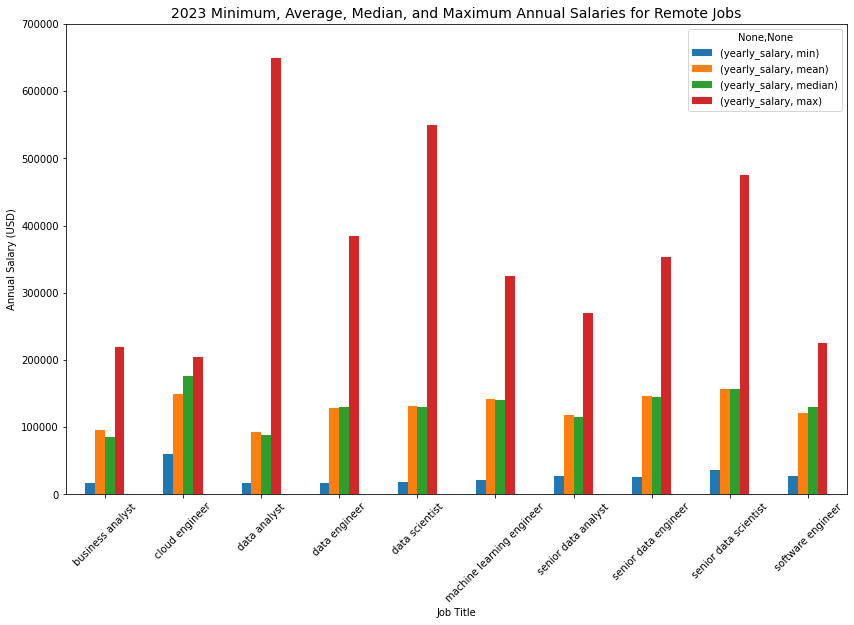

In [217]:
grouper_title_remote_jobs.plot(kind="bar", x="job_title", figsize = (14, (14 / GOLDEN_RATIO)))
plt.ylim(0, 700000)
plt.xticks(rotation=45, )
plt.xlabel("Job Title")
plt.ylabel("Annual Salary (USD)")
plt.title("2023 Minimum, Average, Median, and Maximum Annual Salaries for Remote Jobs", fontsize=14)
plt.ticklabel_format(style="plain", axis="y")

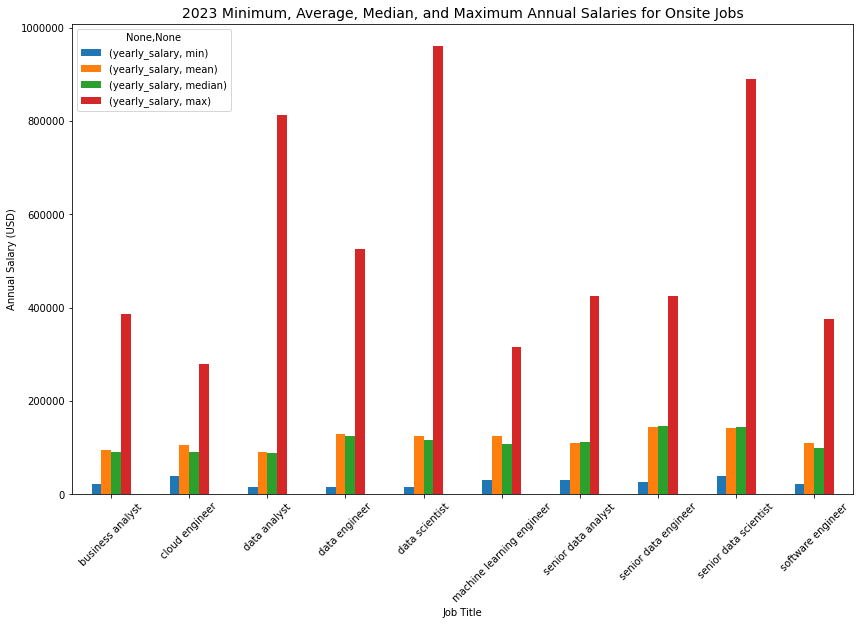

In [218]:
grouper_title_not_remote_jobs.plot(kind="bar", x="job_title", figsize = (14, (14 / GOLDEN_RATIO)))
plt.xticks(rotation=45)
plt.xlabel("Job Title")
plt.ylabel("Annual Salary (USD)")
plt.title("2023 Minimum, Average, Median, and Maximum Annual Salaries for Onsite Jobs", fontsize=14)
plt.ticklabel_format(style="plain", axis="y")

In [ ]:
grouper_need_n_degree = df_verbose.groupby(["need_degree", "job_title"]).agg("count")[["job_id"]]

In [254]:
grouper_need_n_degree = grouper_need_n_degree.reset_index()
grouper_need_n_degree.rename(columns={"job_id": "number_of_jobs"}, inplace=True)

In [255]:
grouper_need_n_degree

need_degree                  job_title  number_of_jobs
0         False           business analyst          109593
1         False             cloud engineer           26919
2         False               data analyst          455157
3         False              data engineer          713727
4         False             data scientist          792507
5         False  machine learning engineer           76326
6         False        senior data analyst           84928
7         False       senior data engineer          198731
8         False      senior data scientist          181492
9         False          software engineer          122981
10         True           business analyst           35813
11         True             cloud engineer           23018
12         True               data analyst          218957
13         True              data engineer          439869
14         True             data scientist           35840
15         True  machine learning engineer            2707
16         True        senior data analyst           36670
17         True       senior data engineer          119827
18         True      senior data scientist            7957
19         True          software engineer          103907

In [256]:
grouper_need_degree = grouper_need_n_degree.loc[grouper_need_n_degree["need_degree"] == True]

In [261]:
grouper_need_degree

need_degree                  job_title  number_of_jobs
10         True           business analyst           35813
11         True             cloud engineer           23018
12         True               data analyst          218957
13         True              data engineer          439869
14         True             data scientist           35840
15         True  machine learning engineer            2707
16         True        senior data analyst           36670
17         True       senior data engineer          119827
18         True      senior data scientist            7957
19         True          software engineer          103907

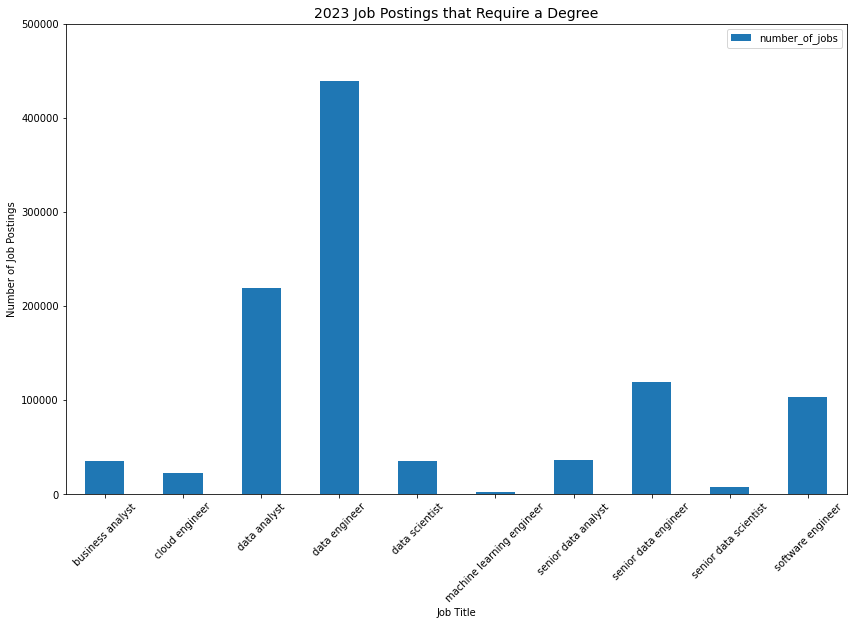

In [257]:
grouper_need_degree.plot(kind="bar", x="job_title", figsize = (14, (14 / GOLDEN_RATIO)))
plt.ylim(0, 500000)
plt.xticks(rotation=45, )
plt.xlabel("Job Title")
plt.ylabel("Number of Job Postings")
plt.title("2023 Job Postings that Require a Degree", fontsize=14)
plt.ticklabel_format(style="plain", axis="y")

In [258]:
grouper_not_need_degree = grouper_need_n_degree.loc[grouper_need_n_degree["need_degree"] == False]

In [262]:
grouper_not_need_degree

need_degree                  job_title  number_of_jobs
0        False           business analyst          109593
1        False             cloud engineer           26919
2        False               data analyst          455157
3        False              data engineer          713727
4        False             data scientist          792507
5        False  machine learning engineer           76326
6        False        senior data analyst           84928
7        False       senior data engineer          198731
8        False      senior data scientist          181492
9        False          software engineer          122981

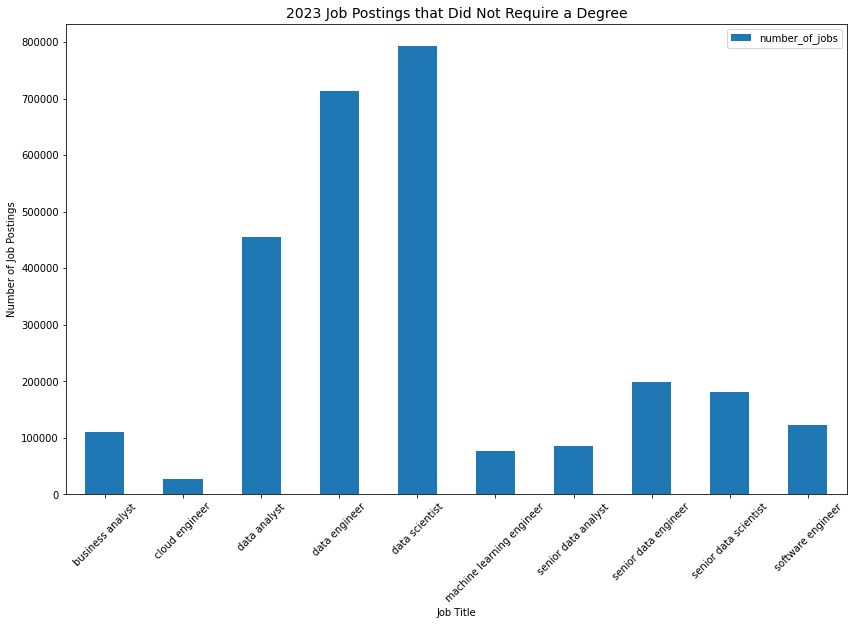

In [ ]:
grouper_not_need_degree.plot(kind="bar", x="job_title", figsize = (14, (14 / GOLDEN_RATIO)))
plt.xticks(rotation=45, )
plt.xlabel("Job Title")
plt.ylabel("Number of Job Postings")
plt.title("2023 Job Postings that Did Not Require a Degree", fontsize=14)
plt.ticklabel_format(style="plain", axis="y")

In [ ]:
display(df_verbose.isna().sum())

job_id                 0
job_title              0
company_name           0
job_location           0
skill                  0
field                  0
job_via                0
job_schedule           0
remote_job             0
need_degree            0
has_insurance          0
country                0
yearly_salary    3616168
dtype: int64

In [17]:
postgres_full_dataset_compact_query = f"""
WITH cvd AS (
    SELECT DISTINCT
        jpf.job_id,
        jpf.job_title_short AS job_title,
        cd.name AS company_name,
        jpf.job_location AS job_location,
        sd.skills AS skill,
        sd.type AS field,
        jpf.job_via AS job_via,
        jpf.job_schedule_type AS job_schedule,
        jpf.job_work_from_home AS remote_job,
        jpf.job_no_degree_mention AS need_degree,
        jpf.job_health_insurance AS has_insurance,
        jpf.job_country AS country,
        jpf.salary_hour_avg AS hourly_salary,
        jpf.salary_year_avg AS yearly_salary
    FROM
        job_postings_fact AS jpf
        LEFT JOIN
        company_dim AS cd
        ON jpf.company_id = cd.company_id
        LEFT JOIN
        skills_job_dim AS sjd
        ON jpf.job_id = sjd.job_id
        LEFT JOIN
        skills_dim AS sd
        ON sjd.skill_id = sd.skill_id
    GROUP BY
        jpf.job_id,
        company_name,
        skill,
        field
)

SELECT
	cvd.job_id,
    cvd.job_title,
    cvd.company_name,
    cvd.job_location,
	STRING_AGG(cvd.skill, ', ') AS requested_skills,
    cvd.field,
    cvd.job_via,
    cvd.job_schedule,
    cvd.remote_job,
    cvd.need_degree,
    cvd.has_insurance,
    cvd.country,
	cvd.hourly_salary AS hourly_salary,
	cvd.yearly_salary AS yearly_salary
FROM
	cvd
GROUP BY
	cvd.job_id,
    cvd.job_title,
    cvd.company_name,
    cvd.job_location,
    cvd.field,
    cvd.job_via,
    cvd.job_schedule,
    cvd.remote_job,
    cvd.need_degree,
    cvd.has_insurance,
    cvd.country,
    cvd.hourly_salary,
	cvd.yearly_salary
"""

postgres_full_dataset_compact_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path="",
    db_type="postgres",
    host_name=HOST_NAME,
    user_name=USER_NAME,
    user_password=USER_PASSWORD,
    db_port=DB_PORT,
    db_name=DB_NAME,
    query_to_exec=postgres_full_dataset_compact_query,
    return_df=True
)

job_id       job_title                       company_name  \
0              0    Data Analyst                         Cryptology   
1              0    Data Analyst                         Cryptology   
2              1    Data Analyst                      Point32Health   
3              1    Data Analyst                      Point32Health   
4              2    Data Analyst                       Apex Systems   
...          ...             ...                                ...   
1910586  1826669  Data Scientist  KTH Royal Institute of Technology   
1910587  1826673  Data Scientist                   General Dynamics   
1910588  1826673  Data Scientist                   General Dynamics   
1910589  1826673  Data Scientist                   General Dynamics   
1910590  1826678  Data Scientist                               Citi   

                 job_location                      requested_skills  \
0                    Anywhere              excel, tableau, power bi   
1                    Anywhere                           sql, python   
2        West Bridgewater, MA                            excel, sas   
3        West Bridgewater, MA                              sas, sql   
4              Naperville, IL                        power bi, ssis   
...                       ...                                   ...   
1910586     Stockholm, Sweden                                  None   
1910587      Bossier City, LA             power bi, looker, tableau   
1910588      Bossier City, LA                         bigquery, aws   
1910589      Bossier City, LA  c#, java, javascript, python, r, sql   
1910590          New York, NY                           python, sql   

                 field          job_via job_schedule  remote_job  need_degree  \
0        analyst_tools     via LinkedIn    Full-time        True        False   
1          programming     via LinkedIn    Full-time        True        False   
2        analyst_tools       via Adzuna    Full-time       False        False   
3          programming       via Adzuna    Full-time       False        False   
4        analyst_tools     via LinkedIn    Full-time       False        False   
...                ...              ...          ...         ...          ...   
1910586           None  via Trabajo.org    Full-time       False        False   
1910587  analyst_tools        via BeBee    Full-time       False        False   
1910588          cloud        via BeBee    Full-time       False        False   
1910589    programming        via BeBee    Full-time       False        False   
1910590    programming     via LinkedIn    Full-time       False        False   

         has_insurance        country hourly_salary yearly_salary  
0                False         Serbia          None          None  
1                False         Serbia          None          None  
2                 True  United States          None          None  
3                 True  United States          None          None  
4                False  United States          None          None  
...                ...            ...           ...           ...  
1910586          False         Sweden          None          None  
1910587           True  United States          None          None  
1910588           True  United States          None          None  
1910589           True  United States          None          None  
1910590          False  United States          None          None  

[1910591 rows x 14 columns]

Function: `display_table_exec_result` took --> 53278654513ns (53.279s)


In [21]:
sqlite_full_dataset_compact_query = f"""
WITH cvd AS (
    SELECT DISTINCT
        jpf.job_id,
        jpf.job_title_short AS job_title,
        cd.name AS company_name,
        jpf.job_location AS job_location,
        sd.skills AS skill,
        sd.type AS field,
        jpf.job_via AS job_via,
        jpf.job_schedule_type AS job_schedule,
        jpf.job_work_from_home AS remote_job,
        jpf.job_no_degree_mention AS need_degree,
        jpf.job_health_insurance AS has_insurance,
        jpf.job_country AS country,
        jpf.salary_hour_avg AS hourly_salary,
        jpf.salary_year_avg AS yearly_salary
    FROM
        job_postings_fact AS jpf
        LEFT JOIN
        company_dim AS cd
        ON jpf.company_id = cd.company_id
        LEFT JOIN
        skills_job_dim AS sjd
        ON jpf.job_id = sjd.job_id
        LEFT JOIN
        skills_dim AS sd
        ON sjd.skill_id = sd.skill_id
    GROUP BY
        jpf.job_id,
        company_name,
        skill,
        field
)

SELECT
	cvd.job_id,
    cvd.job_title,
    cvd.company_name,
    cvd.job_location,
	GROUP_CONCAT(cvd.skill, ', ') AS requested_skills,
    cvd.field,
    cvd.job_via,
    cvd.job_schedule,
    cvd.remote_job,
    cvd.need_degree,
    cvd.has_insurance,
    cvd.country,
	cvd.hourly_salary AS hourly_salary,
	cvd.yearly_salary AS yearly_salary
FROM
	cvd
GROUP BY
	cvd.job_id,
    cvd.job_title,
    cvd.company_name,
    cvd.job_location,
    cvd.field,
    cvd.job_via,
    cvd.job_schedule,
    cvd.remote_job,
    cvd.need_degree,
    cvd.has_insurance,
    cvd.country,
    cvd.hourly_salary,
	cvd.yearly_salary
;
"""

sqlite_full_dataset_compact_query_result = display_table_exec_result(
    table_name=job_postings_fact,
    db_path=real_path_to_db,
    query_to_exec=sqlite_full_dataset_compact_query,
    return_df=True
)

job_id       job_title                       company_name  \
0              0    Data Analyst                         Cryptology   
1              0    Data Analyst                         Cryptology   
2              1    Data Analyst                      Point32Health   
3              1    Data Analyst                      Point32Health   
4              2    Data Analyst                       Apex Systems   
...          ...             ...                                ...   
1910586  1826669  Data Scientist  KTH Royal Institute of Technology   
1910587  1826673  Data Scientist                   General Dynamics   
1910588  1826673  Data Scientist                   General Dynamics   
1910589  1826673  Data Scientist                   General Dynamics   
1910590  1826678  Data Scientist                               Citi   

                 job_location                      requested_skills  \
0                    Anywhere              excel, power bi, tableau   
1                    Anywhere                           python, sql   
2        West Bridgewater, MA                            excel, sas   
3        West Bridgewater, MA                              sas, sql   
4              Naperville, IL                        power bi, ssis   
...                       ...                                   ...   
1910586     Stockholm, Sweden                                  None   
1910587      Bossier City, LA             looker, power bi, tableau   
1910588      Bossier City, LA                         aws, bigquery   
1910589      Bossier City, LA  c#, java, javascript, python, r, sql   
1910590          New York, NY                           python, sql   

                 field          job_via job_schedule  remote_job  need_degree  \
0        analyst_tools     via LinkedIn    Full-time           1            0   
1          programming     via LinkedIn    Full-time           1            0   
2        analyst_tools       via Adzuna    Full-time           0            0   
3          programming       via Adzuna    Full-time           0            0   
4        analyst_tools     via LinkedIn    Full-time           0            0   
...                ...              ...          ...         ...          ...   
1910586           None  via Trabajo.org    Full-time           0            0   
1910587  analyst_tools        via BeBee    Full-time           0            0   
1910588          cloud        via BeBee    Full-time           0            0   
1910589    programming        via BeBee    Full-time           0            0   
1910590    programming     via LinkedIn    Full-time           0            0   

         has_insurance        country  hourly_salary  yearly_salary  
0                    0         Serbia            NaN            NaN  
1                    0         Serbia            NaN            NaN  
2                    1  United States            NaN            NaN  
3                    1  United States            NaN            NaN  
4                    0  United States            NaN            NaN  
...                ...            ...            ...            ...  
1910586              0         Sweden            NaN            NaN  
1910587              1  United States            NaN            NaN  
1910588              1  United States            NaN            NaN  
1910589              1  United States            NaN            NaN  
1910590              0  United States            NaN            NaN  

[1910591 rows x 14 columns]

Function: `display_table_exec_result` took --> 78616083812ns (78.616s)


In [18]:
convert_to_numeric03 = ["hourly_salary", "yearly_salary"]

for column in convert_to_numeric03:
    postgres_full_dataset_compact_query_result[column] = pd.to_numeric(postgres_full_dataset_compact_query_result[column], errors="coerce", downcast="float")

postgres_full_dataset_compact_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910591 entries, 0 to 1910590
Data columns (total 14 columns):
 #   Column            Dtype  
---  ------            -----  
 0   job_id            int64  
 1   job_title         object 
 2   company_name      object 
 3   job_location      object 
 4   requested_skills  object 
 5   field             object 
 6   job_via           object 
 7   job_schedule      object 
 8   remote_job        bool   
 9   need_degree       bool   
 10  has_insurance     bool   
 11  country           object 
 12  hourly_salary     float32
 13  yearly_salary     float32
dtypes: bool(3), float32(2), int64(1), object(8)
memory usage: 151.2+ MB


In [19]:
string_columns = ["job_title", "company_name", "job_location", "requested_skills", "field", "job_via", "job_schedule", "country"]

for column in string_columns:
    postgres_full_dataset_compact_query_result[column] = postgres_full_dataset_compact_query_result[column].astype(str)
    postgres_full_dataset_compact_query_result[column] = postgres_full_dataset_compact_query_result[column].str.lower().str.strip()

postgres_full_dataset_compact_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910591 entries, 0 to 1910590
Data columns (total 14 columns):
 #   Column            Dtype  
---  ------            -----  
 0   job_id            int64  
 1   job_title         object 
 2   company_name      object 
 3   job_location      object 
 4   requested_skills  object 
 5   field             object 
 6   job_via           object 
 7   job_schedule      object 
 8   remote_job        bool   
 9   need_degree       bool   
 10  has_insurance     bool   
 11  country           object 
 12  hourly_salary     float32
 13  yearly_salary     float32
dtypes: bool(3), float32(2), int64(1), object(8)
memory usage: 151.2+ MB


In [20]:
convert_to_category02 = ["job_title", "field", "job_schedule", "country"]

for column in convert_to_category02:
    postgres_full_dataset_compact_query_result[column] = postgres_full_dataset_compact_query_result[column].astype("category")

In [21]:
postgres_full_dataset_compact_query_result["job_id"] = pd.to_numeric(postgres_full_dataset_compact_query_result["job_id"], errors="coerce", downcast="integer")

In [26]:
# # Convert and write Pandas schema to JSON
# df_schema_compact = pd.io.json.json_normalize(dict(zip(postgres_full_dataset_compact_query_result.columns.tolist(), postgres_full_dataset_compact_query_result.dtypes.tolist())))

# df_schema_compact.to_csv("../../../.assets/data/000_common_dataset/datanerd-jobs-full-dataset-compact-in-json.csv", index=False)

In [22]:
postgres_full_dataset_compact_query_result["yearly_salary"] = np.where((postgres_full_dataset_compact_query_result["hourly_salary"].notna() & postgres_full_dataset_compact_query_result["yearly_salary"].isna()), (postgres_full_dataset_compact_query_result["hourly_salary"] * 2080), postgres_full_dataset_compact_query_result["yearly_salary"])

In [28]:
# # Convert the dataframe to a CSV file
# postgres_full_dataset_compact_query_result.to_csv("../../../.assets/data/000_common_dataset/datanerd-jobs-full-dataset-compact-in-csv.csv", index=False)

In [23]:
postgres_full_dataset_compact_query_result.drop(["hourly_salary"], axis=1, inplace=True)

In [26]:
postgres_full_dataset_compact_query_result["yearly_salary"].notna().value_counts()

False    1827805
True       82786
Name: yearly_salary, dtype: int64

In [24]:
df_compact = postgres_full_dataset_compact_query_result

In [25]:
df_compact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910591 entries, 0 to 1910590
Data columns (total 13 columns):
 #   Column            Dtype   
---  ------            -----   
 0   job_id            int32   
 1   job_title         category
 2   company_name      object  
 3   job_location      object  
 4   requested_skills  object  
 5   field             category
 6   job_via           object  
 7   job_schedule      category
 8   remote_job        bool    
 9   need_degree       bool    
 10  has_insurance     bool    
 11  country           category
 12  yearly_salary     float32 
dtypes: bool(3), category(4), float32(1), int32(1), object(4)
memory usage: 87.5+ MB


In [ ]:
# df_compact.to_parquet("../../../.assets/data/000_common_dataset/datanerd-jobs-full-dataset-compact-in-parquet.parquet", index=False)

In [13]:
df_compact = pd.read_parquet("../../../.assets/data/000_common_dataset/datanerd-jobs-full-dataset-compact-in-parquet.parquet")

In [14]:
df_compact.describe(include="all").drop("job_id", axis=1).T.round(1).sort_values(
        "mean", ascending=False
    ).style.background_gradient(cmap="BuGn").bar(subset=["std"], color="red").bar(
        subset=["mean"], color="blue"
    )

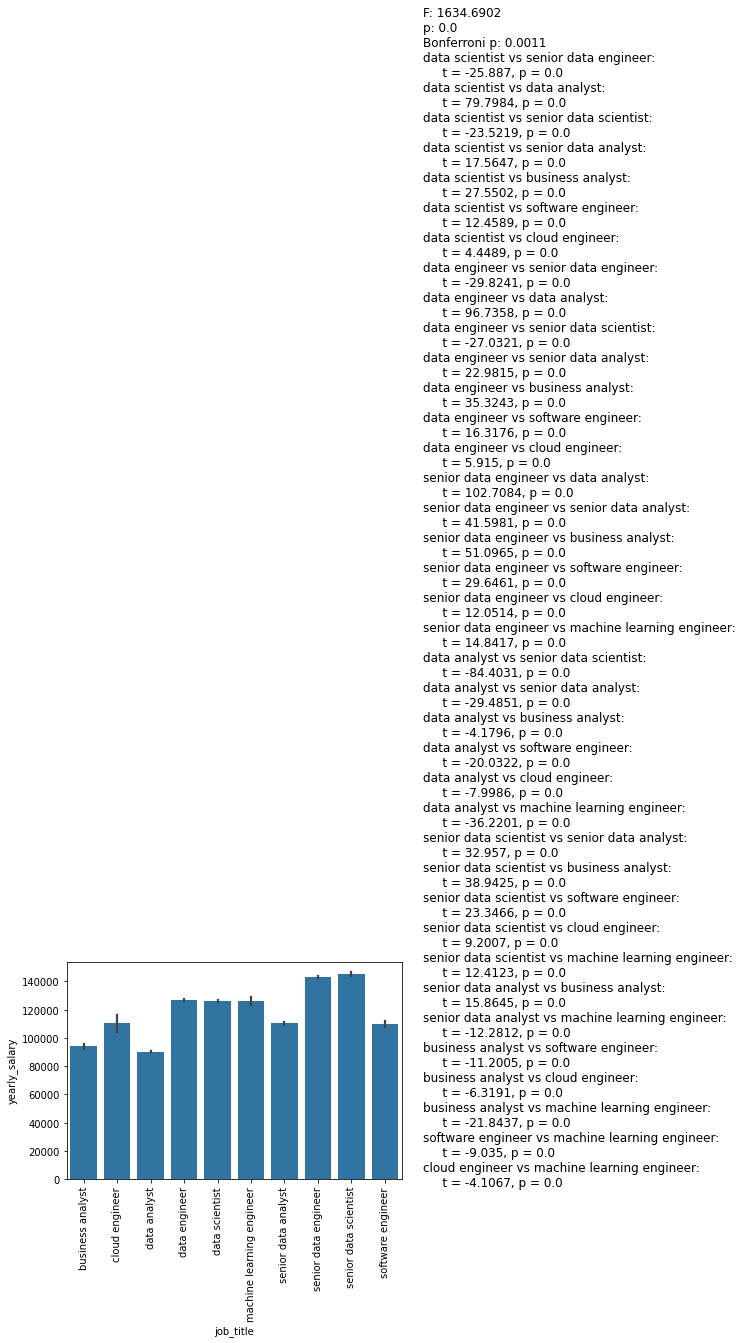

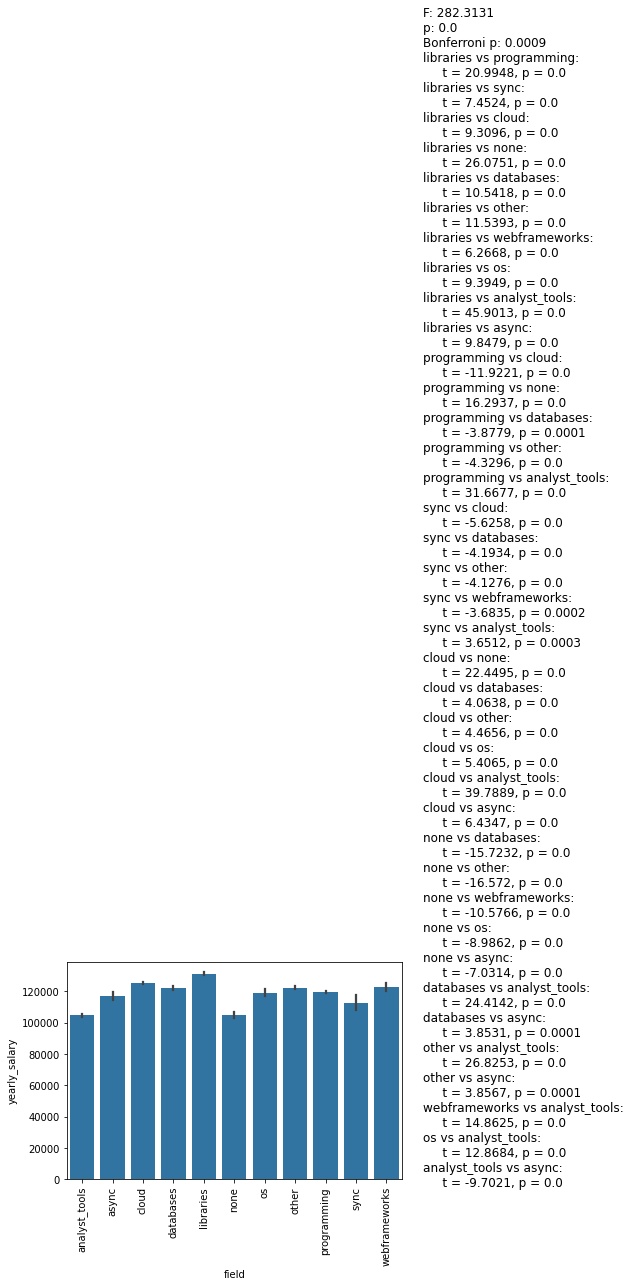

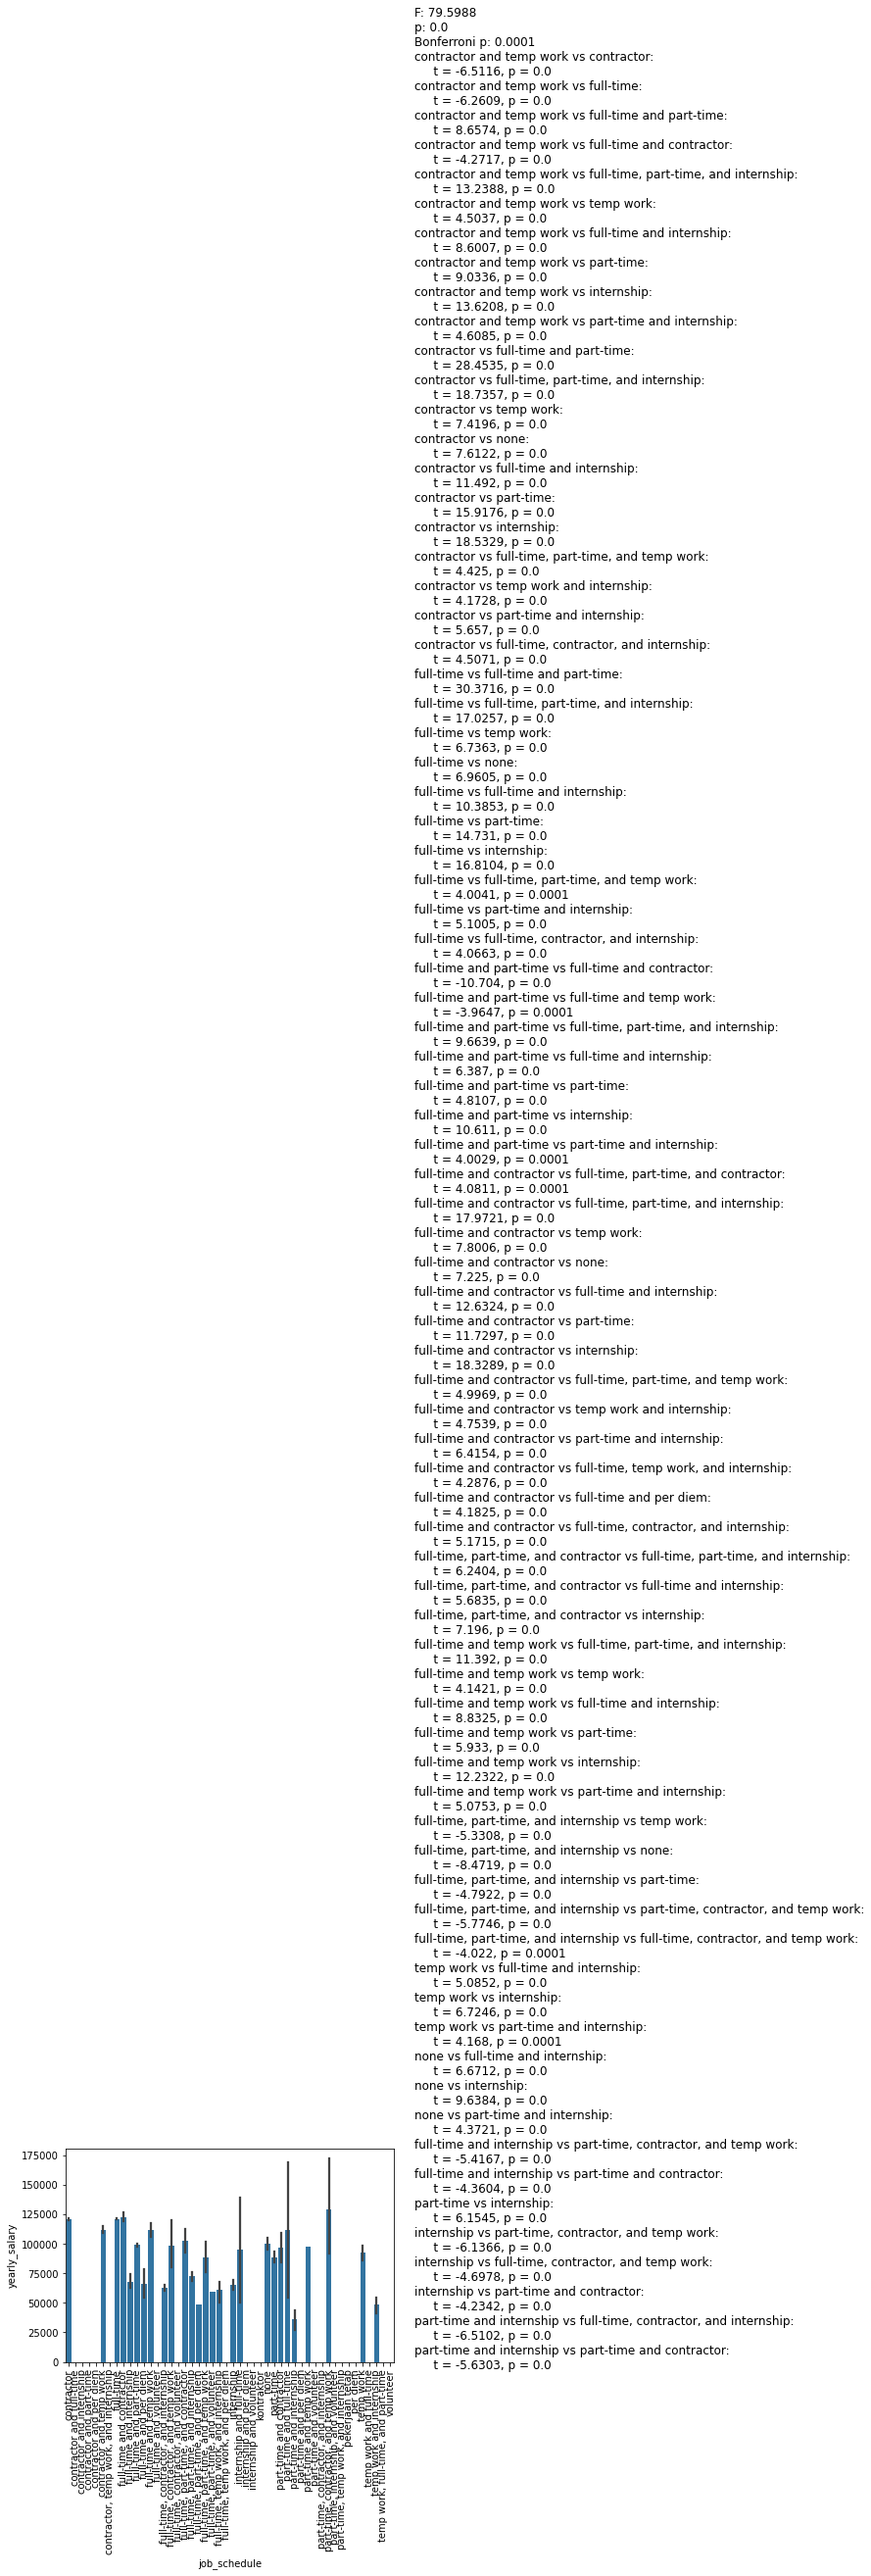

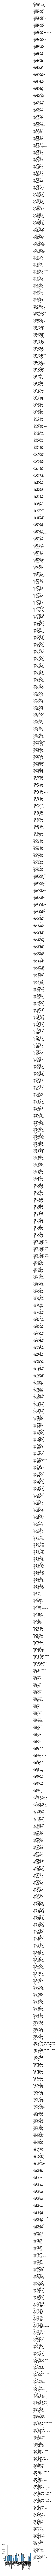

missing missing_% skew      type  num_unique    p   r tau rho  \
job_title     1827805   95.667%   --  category          10  0.0  --  --  --   
field         1827805   95.667%   --  category          11  0.0  --  --  --   
job_schedule  1827805   95.667%   --  category          27  0.0  --  --  --   
country       1827805   95.667%   --  category         112  0.0  --  --  --   

             y = m(x) + b          F  X2  
job_title              --  1634.6902  --  
field                  --   282.3131  --  
job_schedule           --    79.5988  --  
country                --    17.9153  --

In [36]:
bivariate_stats(df_compact, "yearly_salary")

---

## Section 3: Feature Engineering and Modelling

### 3.1. Feature Engineering

##### Confirm features are in appropriate types and drop job_id column

In [15]:
df_compact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910591 entries, 0 to 1910590
Data columns (total 13 columns):
 #   Column            Dtype   
---  ------            -----   
 0   job_id            int32   
 1   job_title         category
 2   company_name      object  
 3   job_location      object  
 4   requested_skills  object  
 5   field             category
 6   job_via           object  
 7   job_schedule      category
 8   remote_job        bool    
 9   need_degree       bool    
 10  has_insurance     bool    
 11  country           category
 12  yearly_salary     float32 
dtypes: bool(3), category(4), float32(1), int32(1), object(4)
memory usage: 87.5+ MB


In [16]:
df_compact.drop(["job_id"], axis=1, inplace=True)

##### Remove rows with NaN/nulls since all the regressor models rejected missing value in the target column/feature

In [17]:
print(df_compact.isna().sum())

job_title                 0
company_name              0
job_location              0
requested_skills          0
field                     0
job_via                   0
job_schedule              0
remote_job                0
need_degree               0
has_insurance             0
country                   0
yearly_salary       1827805
dtype: int64


In [19]:
print(df_compact.shape)

(1910591, 12)


In [18]:
df_compact_without_missing = df_compact.dropna()

In [21]:
print(df_compact_without_missing.shape)

(82786, 12)


##### Process DataFrame for 3 different regressor models

In [19]:
df_mlp = df_compact_without_missing.copy(deep=True)
df_cb = df_compact_without_missing.copy(deep=True)
df_lgb = df_compact_without_missing.copy(deep=True)

In [20]:
cat_columns = df_compact_without_missing.select_dtypes(include=["category", "object", "bool"]).columns.tolist()
num_columns = df_compact_without_missing.select_dtypes(include=["float32", "float64", "int32", "float64", "int64"]).columns.tolist()

In [24]:
print(cat_columns)
print(num_columns)

['job_title', 'company_name', 'job_location', 'requested_skills', 'field', 'job_via', 'job_schedule', 'remote_job', 'need_degree', 'has_insurance', 'country']
['yearly_salary']


In [21]:
X_train, X_test, y_train, y_test  = train_test_split(df_compact_without_missing[cat_columns], df_compact_without_missing[num_columns], test_size=0.17, random_state=RANDOM_SEED)

##### Manually treat DataFrame for 3 different regressor models

In [22]:
X_mlp_train, X_mlp_test, y_mlp_train, y_mlp_test  = train_test_split(df_mlp[cat_columns], df_mlp[num_columns], test_size=0.17, random_state=RANDOM_SEED)

In [23]:
X_cb_train, X_cb_test, y_cb_train, y_cb_test  = train_test_split(df_cb[cat_columns], df_cb[num_columns], test_size=0.17, random_state=RANDOM_SEED)

In [24]:
df_lgb[cat_columns] = df_lgb[cat_columns].astype("category")

X_lgb_train, X_lgb_test, y_lgb_train, y_lgb_test  = train_test_split(df_lgb[cat_columns], df_lgb[num_columns], test_size=0.17, random_state=RANDOM_SEED)

X_lgb_train_data = lgb.Dataset(X_lgb_train, label=y_lgb_train, categorical_feature=cat_columns)
X_lgb_test_data = lgb.Dataset(X_lgb_test, label=y_lgb_test, reference=X_lgb_train_data, categorical_feature=cat_columns)

In [29]:
print(X_lgb_train_data.data.shape)

(68712, 11)


In [30]:
print(y_lgb_train.shape)

(68712, 1)


### 3.2. Modelling

InvalidParameterError: The 'scoring' parameter of cross_validate must be a str among {'precision_weighted', 'roc_auc_ovr', 'neg_log_loss', 'precision_micro', 'neg_mean_poisson_deviance', 'f1_weighted', 'precision_macro', 'neg_negative_likelihood_ratio', 'balanced_accuracy', 'r2', 'average_precision', 'rand_score', 'homogeneity_score', 'positive_likelihood_ratio', 'accuracy', 'recall', 'f1', 'f1_macro', 'mutual_info_score', 'f1_samples', 'max_error', 'neg_mean_gamma_deviance', 'roc_auc_ovo_weighted', 'jaccard_macro', 'recall_weighted', 'neg_brier_score', 'roc_auc_ovo', 'v_measure_score', 'explained_variance', 'roc_auc', 'top_k_accuracy', 'neg_mean_squared_log_error', 'matthews_corrcoef', 'neg_mean_absolute_percentage_error', 'adjusted_mutual_info_score', 'jaccard', 'recall_samples', 'jaccard_weighted', 'neg_median_absolute_error', 'recall_macro', 'jaccard_micro', 'normalized_mutual_info_score', 'neg_root_mean_squared_error', 'adjusted_rand_score', 'f1_micro', 'precision', 'neg_mean_squared_error', 'precision_samples', 'completeness_score', 'fowlkes_mallows_score', 'roc_auc_ovr_weighted', 'neg_mean_absolute_error', 'recall_micro', 'jaccard_samples'}, a callable or None.

In [25]:
## Function to evaluate a regression model
@timing_function
def evaluate_regression_model(model_name, X_data, y_data, messages=True, return_scores=False):
    scores_obj = {}

    rmse = make_scorer(mean_squared_error, squared=False)
    r2 = make_scorer(r2_score)
    mae = make_scorer(mean_absolute_error)
    mdae = make_scorer(median_absolute_error)
    mpl = make_scorer(mean_pinball_loss)

    scorers = {"rmse": rmse, "r2": r2, "mae": mae, "mdae": mdae, "mpl": mpl}
    scores = cross_validate(model_name, X_data, y_data, cv=3, scoring=scorers, return_train_score = True)

    if messages:
        for item in scorers:
            print(f"{model_name.__class__.__name__} {item} score: {np.mean(scores[f'test_{item}'])}")
    
    if return_scores:
        return scores

In [35]:
dummy_reg_model = DummyRegressor()
dummy_reg_model.fit(X_train, y_train)

evaluate_regression_model(dummy_reg_model, X_test, y_test)

DummyRegressor rmse score: 46801.526041666664
DummyRegressor r2 score: -0.0008188948997042514
DummyRegressor mae score: 35611.75390625
DummyRegressor mdae score: 29193.4375
DummyRegressor mpl score: 17805.876953125
Function: `evaluate_regression_model` took --> 133895029ns (0.134s)


In [32]:
cbe_encoder = ce.CatBoostEncoder(cols=cat_columns, random_state=RANDOM_SEED, verbose=0)
cbe_encoder.fit(X_mlp_train, y_mlp_train)

X_mlp_train_enc = cbe_encoder.transform(X_mlp_train)
X_mlp_test_enc = cbe_encoder.transform(X_mlp_test)

mlp_reg_model = MLPRegressor(hidden_layer_sizes=(17,17,17), activation="relu", random_state=RANDOM_SEED, max_iter=2311, early_stopping=True, validation_fraction=0.13, n_iter_no_change=7,).fit(X_mlp_train_enc, y_mlp_train)

evaluate_regression_model(mlp_reg_model, X_mlp_test_enc, y_mlp_test)

MLPRegressor rmse score: 32100.038326737744
MLPRegressor r2 score: 0.5291151580648892
MLPRegressor mae score: 22335.851409562598
MLPRegressor mdae score: 16528.511341455483
MLPRegressor mpl score: 11167.925704781299
Function: `evaluate_regression_model` took --> 15547077953ns (15.547s)


CatBoostError: Invalid loss_function='Logloss': for regressor use RMSE, MultiRMSE, SurvivalAft, MAE, Quantile, LogLinQuantile, Poisson, MAPE, Lq or custom objective object

In [34]:
cat_reg_model = CatBoostRegressor(cat_features=cat_columns, random_state=RANDOM_SEED, loss_function="RMSE", verbose=0)
cat_reg_model.fit(X_cb_train, y_cb_train)

In [35]:
evaluate_regression_model(cat_reg_model, X_cb_test, y_cb_test)

CatBoostRegressor rmse score: 35251.93979684793
CatBoostRegressor r2 score: 0.4322655377894143
CatBoostRegressor mae score: 24792.850338624314
CatBoostRegressor mdae score: 18946.84091079052
CatBoostRegressor mpl score: 12396.425169312157
Function: `evaluate_regression_model` took --> 72253131406ns (72.253s)


In [32]:
lgb_reg_model = lgb.LGBMRegressor(max_bin=50000, random_state=RANDOM_SEED, verbose=0)

lgb_reg_model.fit(X_lgb_train, y_lgb_train)

LGBMRegressor(max_bin=50000, random_state=42, verbose=0)

In [33]:
evaluate_regression_model(lgb_reg_model, X_lgb_test, y_lgb_test)

LGBMRegressor rmse score: 37165.07290760835
LGBMRegressor r2 score: 0.36898673808076204
LGBMRegressor mae score: 26374.151532980624
LGBMRegressor mdae score: 20285.435660793402
LGBMRegressor mpl score: 13187.075766490312
Function: `evaluate_regression_model` took --> 2238644071ns (2.239s)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

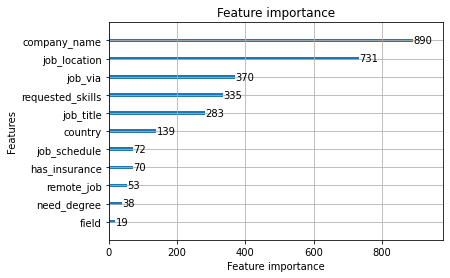

In [34]:
lgb.plot_importance(lgb_reg_model)

<AxesSubplot: >

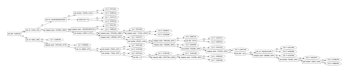

In [35]:
lgb.plot_tree(lgb_reg_model)

---

## Section 4: Model Hyperparameter Tuning

In [26]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

##### MLPRegressor Tuning

In [42]:
mlp_halving_search_space = {
        "hidden_layer_sizes": [(3,3,3), (17,17,17)],
        "activation": ["logistic", "tanh", "relu"],
        "learning_rate": ["constant", "invscaling", "adaptive"],
        "solver": ["lbfgs", "sgd", "adam"],
        "max_iter": [109, 857],
        "n_iter_no_change": [2, 17],
        "early_stopping": [True, False],
    }

In [ ]:
mlp_bayes_search_space = {
        "hidden_layer_sizes": Integer(3, 17),
        "activation": Categorical(categories=["logistic", "tanh", "relu"]),
        "learning_rate": Categorical(categories=["constant", "invscaling", "adaptive"]),
        "solver": Categorical(categories=["lbfgs", "sgd", "adam"]),
        "max_iter": Integer(109, 857),
        "n_iter_no_change": Integer(2, 17),
        "early_stopping": Categorical(categories=[True, False]),
    }

In [ ]:
mlp_hgscv_best_params, mlp_bscv_best_params, *args = model_optimiser(
    mlp_reg_model,
    X_mlp_train_enc,
    y_mlp_train,
    cv_val=5,
    halving_param_spaces=mlp_halving_search_space,
    bayes_param_spaces=mlp_bayes_search_space,
    title="Model Optimisation for Regression",
)

##### CatBoostRegressor Tuning

In [ ]:
cb_halving_search_space00 = {
    "iterations": (np.linspace(start=229, stop=2311, num=3,).astype(int)),
    "depth": (np.linspace(start=2, stop=16, num=3,).astype(int)),
    "learning_rate": np.linspace(start=0.03, stop=0.5, num=3,).round(2),
    "subsample": np.linspace(start=0.5, stop=0.8, num=3,).round(2),
    "colsample_bylevel": np.linspace(start=0.05, stop=0.7, num=3,).round(2),
    "min_data_in_leaf": (np.linspace(start=3, stop=59, num=3,).astype(int)),
}


In [39]:
cb_halving_search_space = {
    "iterations": (np.linspace(start=229, stop=2311, num=3,).astype(int)),
    "depth": (np.linspace(start=2, stop=16, num=3,).astype(int)),
    "learning_rate": np.linspace(start=0.03, stop=0.5, num=3,).round(2),
}

In [ ]:
cb_bayes_search_space00 = {
    "iterations": Integer(229, 2311),
    "depth": Integer(2, 16),
    "learning_rate": Real(0.003, 0.5),
    "subsample": Real(0.5, 0.8),
    "colsample_bylevel": Real(0.05, 0.7),
    "min_data_in_leaf": Integer(3, 59),
}

In [ ]:
cb_bayes_search_space = {
    "iterations": Integer(229, 2311),
    "depth": Integer(2, 16),
    "learning_rate": Real(0.003, 0.5),
}

In [ ]:
cb_hscv_best_params, cb_bscv_best_params, tuned_cb_hscv_model, tuned_cb_bscv_model = model_optimiser(
    cat_reg_model,
    X_cb_train,
    y_cb_train,
    cv_val=2,
    halving_param_spaces=cb_halving_search_space,
    skopt_bayes_param_spaces=cb_bayes_search_space,
    title="Model Optimisation for Regression",
    return_fitted_models=True,
    verbose_level=2,
)

In [ ]:
evaluate_regression_model(tuned_cb_hscv_model, X_cb_test, y_cb_test)

CatBoostRegressor rmse score: 35007.07305478638
CatBoostRegressor r2 score: 0.4402458514989158
CatBoostRegressor mae score: 24585.889641325153
CatBoostRegressor mdae score: 19008.64485549683
CatBoostRegressor mpl score: 12292.944820662577


The 'scoring' parameter of BayesSearchCV must be a str among {'f1_macro', 'recall_samples', 'f1_micro', 'mutual_info_score', 'neg_mean_absolute_percentage_error', 'roc_auc', 'roc_auc_ovr', 'recall', 'jaccard_samples', 'roc_auc_ovo_weighted', 'roc_auc_ovr_weighted', 'neg_mean_poisson_deviance', 'neg_brier_score', 'precision', 'roc_auc_ovo', 'v_measure_score', 'average_precision', 'jaccard', 'neg_negative_likelihood_ratio', 'precision_macro', 'explained_variance', 'precision_weighted', 'neg_log_loss', 'neg_mean_gamma_deviance', 'jaccard_macro', 'f1', 'normalized_mutual_info_score', 'matthews_corrcoef', 'top_k_accuracy', 'positive_likelihood_ratio', 'neg_mean_squared_log_error', 'jaccard_weighted', 'precision_micro', 'r2', 'recall_micro', 'adjusted_rand_score', 'max_error', 'homogeneity_score', 'rand_score', 'recall_weighted', 'accuracy', 'adjusted_mutual_info_score', 'f1_samples', 'f1_weighted', 'completeness_score', 'neg_mean_absolute_error', 'neg_median_absolute_error', 'jaccard_micro', 'neg_root_mean_squared_error', 'balanced_accuracy', 'neg_mean_squared_error', 'recall_macro', 'fowlkes_mallows_score', 'precision_samples'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got 'r2_score' instead.

In [27]:
## Fine-tuned hyperparameters obtained from Kaggle cloud

best_hscv_cb_params = {
    "subsample": 0.8,
    "min_data_in_leaf": 59,
    "learning_rate": 0.03,
    "iterations": 1270,
    "depth": 2,
    "colsample_bylevel": 0.37,
}

best_skopt_bscv_cb_params = {
    "colsample_bylevel": 0.6933758451800026,
    "depth": 12,
    "iterations": 2311,
    "learning_rate": 0.12029154449275392,
    "min_data_in_leaf": 7,
    "subsample": 0.7959164223134585
}

In [29]:
best_cb_from_hscv_reg_model = CatBoostRegressor(cat_features=cat_columns, random_state=RANDOM_SEED, loss_function="RMSE", verbose=0, **best_hscv_cb_params)
best_cb_from_hscv_reg_model.fit(X_cb_train, y_cb_train)

In [30]:
evaluate_regression_model(best_cb_from_hscv_reg_model, X_cb_test, y_cb_test)

CatBoostRegressor rmse score: 36050.49282018726
CatBoostRegressor r2 score: 0.40625621245520377
CatBoostRegressor mae score: 25674.87698521366
CatBoostRegressor mdae score: 20009.752469914933
CatBoostRegressor mpl score: 12837.43849260683
Function: `evaluate_regression_model` took --> 19466687063ns (19.467s)


In [31]:
best_cb_from_skopt_bscv_reg_model = CatBoostRegressor(cat_features=cat_columns, random_state=RANDOM_SEED, loss_function="RMSE", verbose=0, **best_skopt_bscv_cb_params)
best_cb_from_skopt_bscv_reg_model.fit(X_cb_train, y_cb_train)

In [32]:
evaluate_regression_model(best_cb_from_skopt_bscv_reg_model, X_cb_test, y_cb_test)

CatBoostRegressor rmse score: 36537.035223560124
CatBoostRegressor r2 score: 0.390091267235208
CatBoostRegressor mae score: 25782.705607491633
CatBoostRegressor mdae score: 19837.47706186702
CatBoostRegressor mpl score: 12891.352803745816
Function: `evaluate_regression_model` took --> 1148663600813ns (1148.664s)


In [33]:
cb_feature_importances = pd.DataFrame({"feature": X_cb_train.columns, "importance": best_cb_from_hscv_reg_model.get_feature_importance()})
top_10_cb_features = cb_feature_importances.sort_values(by="importance", ascending=False).head(10)

In [34]:
top_10_cb_features

feature  importance
1       company_name   41.545859
0          job_title   23.395639
5            job_via   18.633909
2       job_location   10.958690
6       job_schedule    1.841788
3   requested_skills    0.922073
8        need_degree    0.751036
10           country    0.703790
4              field    0.675885
9      has_insurance    0.498662

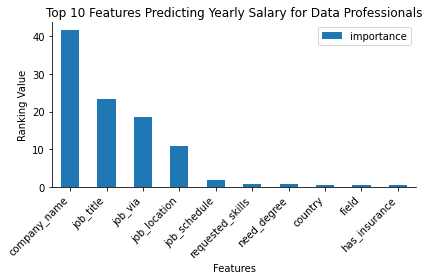

In [40]:
top_10_cb_features.plot.bar(x="feature", y="importance")
# Remove top and right borders
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Ranking Value")
plt.title("Top 10 Features Predicting Yearly Salary for Data Professionals")
plt.tight_layout()
plt.show()

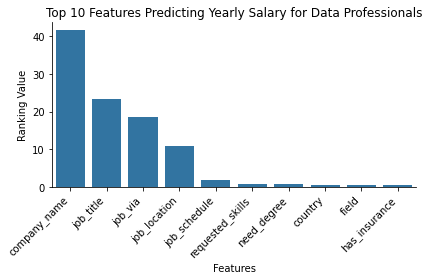

In [ ]:
cb_ax = sns.barplot(data=top_10_cb_features, x="feature", y="importance", errorbar=None)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Ranking Value")
plt.title("Top 10 Features Predicting Yearly Salary for Data Professionals")

plt.tight_layout()
plt.show()